<a href="https://colab.research.google.com/github/Angelvj/Alzheimer-disease-classification/blob/main/code/ad_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
kaggle = False

# Imports

In [8]:
import os, shutil, re
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
if kaggle:
    from kaggle_datasets import KaggleDatasets
    from kaggle_secrets import UserSecretsClient
else:
    from google.colab import drive
import nibabel as nib

# Import the most used layers
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Input, BatchNormalization, Dropout

# Hardware config.

In [9]:
DEVICE = 'GPU' # or TPU
tpu = None

if DEVICE == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        STRATEGY = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        print('Could not connect to TPU, setting default strategy')
        tpu = None
        STRATEGY = tf.distribute.get_strategy()
elif DEVICE == 'GPU':
    STRATEGY = tf.distribute.MirroredStrategy()
    
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = STRATEGY.num_replicas_in_sync

print(f'Number of accelerators: {REPLICAS}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators: 1


# Functions for loading dataset

In [10]:
def read_tfrecord(example):
    
    tfrec_format = {
        "image": tf.io.VarLenFeature(tf.float32),
        "one_hot_label": tf.io.VarLenFeature(tf.float32)
    }

    example = tf.io.parse_single_example(example, tfrec_format)
    one_hot_label = tf.sparse.to_dense(example['one_hot_label'])
    one_hot_label = tf.reshape(one_hot_label, [NUM_CLASSES])
    image = tf.reshape(tf.sparse.to_dense(example['image']), IMG_SHAPE)
    # TPU needs size to be known statically, so this doesn't work
    #     image  = tf.reshape(example['image'], example['shape']) 
    return image, one_hot_label

# =========================================================================
# The three functions below are used for generating a dataset directly from
# the filenames of the data (via a callable generator).
# ==========================================================================

def load_image(path):    

    img = nib.load(path)
    img = np.asarray(img.dataobj, dtype=np.float32)
    img = np.expand_dims(img, axis=3) # Add channel axis
    return img

def parse_file(filename, label):

    image = load_image(filename)
    image = np.nan_to_num(image, copy=False)
    label = np.eye(3, dtype=np.float32)[label]

    return image, label

def generator_fn(filenames, labels):

    def images_generator():

        for X, y in zip(filenames, labels):
            X, y = parse_file(X, y)
            yield X, y
            
    return images_generator

def load_dataset(filenames, labels, use_tfrec, no_order=True):
    
    if use_tfrec:
        # Allow order-altering optimizations
        option_no_order = tf.data.Options()
        option_no_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
        if no_order:
            dataset = dataset.with_options(option_no_order)
        dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTO)

    else:
        dataset = tf.data.Dataset.from_generator(generator_fn(filenames, labels),
            output_signature=(
                 tf.TensorSpec(shape=IMG_SHAPE, dtype=tf.float32),
                 tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.float32)))

    return dataset

def count_data_items(filenames, use_tfrec):
    
    if use_tfrec:
        n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
            for filename in filenames]
        return np.sum(n)
    else:
        return len(filenames)

def get_dataset(filenames, labels=None, use_tfrec=True, batch_size = 4, train=False, augment=False, cache=True, no_order=True):
    
    dataset =  load_dataset(filenames, labels, use_tfrec, no_order)
    
    if cache:
        dataset = dataset.cache() # Do it only if dataset fits in ram
    if train:
        dataset = dataset.repeat()
        if augment:
            raise NotImplementedError
#             dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        dataset = dataset.shuffle(count_data_items(filenames, use_tfrec))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Train schedule

**Note**: not used yet (will be used when pretrain)

In [11]:
# Only for pretraining
def get_lr_callback(batch_size=4, verbose=False):
    lr_start = 0.00001
    lr_max = 0.00004 * batch_size
    lr_min = 0.00001
    lr_rampup_epochs = 3
    lr_sustain_epochs = 0
    lr_exp_decay = 0.7

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = verbose)
    return lr_callback

# For training from scratch
def get_lr_decay_callback(batch_size=4, verbose=False):
    lr_max = 0.00001
    lr_exp_decay = 0.9
    lr_min = 0.000001
    
    def lrfn(epoch):
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch) + lr_min
        return lr
        
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = verbose)
    return lr_callback

# Build models

In [12]:
# TODO (not important): define models in another file
def build_model_0(input_shape):
    
    inputs = tf.keras.layers.Input(input_shape)
    
    x = tf.keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)
    
    outputs = Dense(units=3, activation="softmax")(x)
   
    model = tf.keras.Model(inputs, outputs, name="model_0")
    return model

def build_model_1(input_shape):
    
    inputs = tf.keras.layers.Input(input_shape)
    
    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)
    
    outputs = Dense(units=3, activation="softmax")(x)
    
    model = tf.keras.Model(inputs, outputs, name="model_1")
    return model

def build_model_2(input_shape):
    
    inputs = tf.keras.layers.Input(input_shape)

    x = Conv3D(filters=16, kernel_size=5, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=64, kernel_size=5, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=128, kernel_size=5, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="model_2")
    return model

def build_model_3(input_shape):
    
    inputs = tf.keras.layers.Input(input_shape)

    x = Conv3D(filters=16, kernel_size=3, activation="relu")(inputs)
    x = Conv3D(filters=16, kernel_size=3, activation='relu')(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = Conv3D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = BatchNormalization()(x)
    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = Conv3D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    # x = Dropout(rate=0.1)(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="model_3")
    return model


def build_model_4(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    x = Conv3D(filters=16, kernel_size=3, activation="relu")(inputs)
    x = Conv3D(filters=16, kernel_size=3, activation='relu')(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = Conv3D(filters=64, kernel_size=3, activation='relu')(x)
    x = Conv3D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = BatchNormalization()(x)
    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = Conv3D(filters=128, kernel_size=3, activation='relu')(x)
    x = Conv3D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    # x = Dropout(rate=0.1)(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="model_4")
    return model

# Visualization

In [13]:
def plot_epochs_history(num_epochs, history):

    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(num_epochs), history['accuracy'], '-o', label='Train acc',
            color = '#ff7f0e')
    plt.plot(np.arange(num_epochs), history['val_accuracy'], '-o', label='Val acc',
            color = '#1f77b4')
    x = np.argmax(history['val_accuracy']); y = np.max(history['val_accuracy'])
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=150, color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max acc\n%.2f'%y,size=14)
    plt.ylabel('ACC', size=14); plt.xlabel('Epoch', size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(num_epochs),history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(num_epochs),history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'] ); y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=150,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.legend(loc=3)
    plt.show()  
    
def plot_cm(labels, predictions):
    
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Functions for training and evaluating models

**Note**: bug in tf 2.4.1 (accuracies showed while training is different than the ones returned in history). [See issue here](https://github.com/tensorflow/tensorflow/issues/48033)

In [14]:
def evaluate_model_kfold(model_builder, train_filenames, n_folds, batch_size, epochs, 
                         plot_fold_results = True, plot_avg_results = True, train_labels=None, 
                         stratify=False, shuffle=True, random_state=None, use_tfrec=True):
    
    # np_rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(random_state)))
    folds_histories = []

    if stratify:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=random_state)
    else:
        skf = KFold(n_splits=n_folds, shuffle=shuffle, random_state=random_state)

    for fold, (idx_train, idx_val) in enumerate(skf.split(train_filenames, train_labels)):
        if tpu != None:
            tf.tpu.experimental.initialize_tpu_system(tpu)

        # np_rs.shuffle(idx_train)
        X_train = train_filenames[idx_train]
        X_val = train_filenames[idx_val]
        y_train = None if use_tfrec is None else train_labels[idx_train]
        y_val = None if use_tfrec is None else train_labels[idx_val]

        # Build model
        tf.keras.backend.clear_session()
        with STRATEGY.scope():
            model = model_builder(input_shape=IMG_SHAPE)
            # Optimizers and Losses create TF variables --> should always be initialized in the scope
            OPT = tf.keras.optimizers.Adam(learning_rate=LR)
            LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.00)
            model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS, steps_per_execution=8)

        # Train
        print(f'Training for fold {fold + 1} of {n_folds}...')
        cbks = [get_lr_decay_callback(batch_size)] # TODO: poner bien
        history = model.fit(
            get_dataset(X_train, y_train,  use_tfrec, train=True, augment=False, batch_size=batch_size), 
            epochs = EPOCHS, callbacks = cbks,
            steps_per_epoch = max(1, int(np.rint(count_data_items(X_train, use_tfrec)/batch_size))),
            validation_data = get_dataset(X_val, y_val, use_tfrec, batch_size = batch_size, train=False), 
            validation_steps= max(1, int(np.rint(count_data_items(X_val,use_tfrec)/batch_size))))
    
        if tf.__version__ == "2.4.1": # TODO: delete when tensorflow fixes the bug
            scores = model.evaluate(get_dataset(X_train, y_train, use_tfrec, batch_size = batch_size, train=False), 
                                    batch_size = batch_size, steps = max(1, int(np.rint(count_data_items(X_train, use_tfrec)/batch_size))))
            for i in range(len(model.metrics_names)):
                history.history[model.metrics_names[i]][-1] = scores[i]
            
        folds_histories.append(history.history)
        
        if plot_fold_results:
            plot_epochs_history(epochs, history.history)
        
    avg_history = avg_results_per_epoch(folds_histories)
            
    if plot_avg_results:
        
        plot_epochs_history(epochs, avg_history)

        print('-'*80)
        print('Results per fold')
        for i in range(n_folds):
            print('-'*80)
            out = f"> Fold {i + 1} - loss: {folds_histories[i]['loss'][-1]} - accuracy: {folds_histories[i]['accuracy'][-1]}"
            out += f" - val_loss.: {folds_histories[i]['val_loss'][-1]} - val_accuracy: {folds_histories[i]['val_accuracy'][-1]}"
            print(out)

        print('-'*80)
        print('Average results over folds (on last epoch):')
        print(f"> loss: {avg_history['loss'][-1]}")
        print(f"> accuracy: {avg_history['accuracy'][-1]}")
        print(f"> cval_loss: {avg_history['val_loss'][-1]}")
        print(f"> cval_accuracy: {avg_history['val_accuracy'][-1]}")
        print('-'*80)

    return folds_histories

def repeated_kfold(model_builder, train_filenames, n_folds, batch_size, epochs, reps=5, train_labels=None,
                   stratify=True, shuffle=True, random_state=None, use_tfrec=True):
    
    reps_histories = []
    
    for i in range(reps):
        print(f'Repetition {i + 1}')
        folds_histories = evaluate_model_kfold(model_builder, train_filenames, n_folds,
                                             batch_size, epochs, train_labels=train_labels, stratify=stratify,
                                             shuffle=shuffle, random_state=random_state, use_tfrec=use_tfrec)

        reps_histories.append(folds_histories)

    return reps_histories

def test_model_rkfold(model_builder, results_filename):
    # Evaluate model with repeated k-fold (because of the high variance)
    reps_results = repeated_kfold(model_builder, X_train, FOLDS, BATCH_SIZE, EPOCHS, reps=REPS, train_labels=y_train,
                   random_state=SEED)
    
    # Save results to disk
    f = open(results_filename, 'w' )
    f.write(repr(reps_results))
    f.close()
    
def train_model(model_builder):
    # Test model
    with STRATEGY.scope():
        OPT = tf.keras.optimizers.Adam(learning_rate=LR)
        LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.00)
        model = model_builder(IMG_SHAPE)
        model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)


    cbks = [get_lr_decay_callback(BATCH_SIZE)] # TODO: poner bien

    history = model.fit(
        get_dataset(X_train, train=True, batch_size=BATCH_SIZE), 
        epochs = EPOCHS, callbacks = cbks,
        steps_per_epoch = int(np.rint(count_data_items(X_train, use_tfrec=True)/BATCH_SIZE))
        )
    
    return model
    
def avg_results_per_epoch(histories):
    
    keys = list(histories[0].keys())
    epochs = len(histories[0][keys[0]])
    
    avg_histories = dict()
    for key in keys:
        avg_histories[key] = [np.mean([x[key][i] for x in histories]) for i in range(epochs)]
        
    return avg_histories

def avg_reps_results(reps_histories):
    return avg_results_per_epoch([avg_results_per_epoch(history) for history in reps_histories])
    
def show_rkfold_results(results_file):
    # Load results from disk
    f = open(results_file, 'r')
    reps_results = eval(f.read())
    
    reps_avgd_per_kfold = [avg_results_per_epoch(history) for history in reps_results]
    reps_avg = avg_results_per_epoch(reps_avgd_per_kfold)
    
    # Plot final result over epochs
    plot_epochs_history(EPOCHS, reps_avg)
    
    print('-'*80)
    print('Results per repetition (on last epoch)')
    for i in range(REPS):
        print('-'*80)
        print(f"> Repetition {i + 1} - Loss: {reps_avgd_per_kfold[i]['val_loss'][-1]} - Accuracy : {reps_avgd_per_kfold[i]['val_accuracy'][-1]}")

    print('-'*80)
    print('Average results over repetitions (on last epoch):')
    print(f"> Train Accuracy: {reps_avg['accuracy'][-1]}")
    print(f"> Train Loss: {reps_avg['loss'][-1]}")
    print(f"> CV accuracy: {reps_avg['val_accuracy'][-1]}")
    print(f"> CV Loss: {reps_avg['val_loss'][-1]}")
    print('-'*80)
    
def show_test_results(model):
    results = model.evaluate(get_dataset(X_test))

    predictions = model.predict(get_dataset(X_test, no_order=False))
    y_pred = np.argmax(predictions, axis=1)

    plot_cm(y_test, y_pred)
    print(classification_report(y_test, y_pred))

# Prepare datasets and evaluation constants

In [15]:
SEED = 268 # Arbitrary seed

# Name of different datasets used
TFREC_DATASETS = ['tfrec-pet-spatialnorm-elastic',
                  'tfrec-pet-spatialnorm-elastic-maxintensitynorm',
                  'tfrec-pet-spatialnorm-elastic-standarized'
                 ]
IMG_DATASETS = ['ad-preprocessed', None, None]

# Shape of images on each dataset
SHAPES = [(79, 95, 68, 1), (79, 95, 68, 1), (79, 95, 68, 1), (79, 95, 68, 1)]

# Number of repetitions and folds for repeated k-fold
REPS = 5
FOLDS = 10

# Different classes on the dataset
CLASSES = ['NOR', 'AD', 'MCI']
NUM_CLASSES = len(CLASSES)

METRICS = ['accuracy']

if kaggle:
    INPUT_DATAPATH = '/kaggle/input/' if tpu is None else None
    METADATA_PATH = '/kaggle/input/'
else:
    drive.mount('/content/drive') 
    INPUT_DATAPATH = '/content/drive/MyDrive/data/'
    METADATA_PATH = '/content/drive/MyDrive/data/'

Mounted at /content/drive


# Training/testing with PET images

## Spatially normalized PET - elastic transformations

In [16]:
# # ========================  NOT USED =========================
# # Training model from images directly. Note: USE ONLY WITH GPU

# DS = IMG_DATASETS[0] # Select dataset
# IMG_SHAPE = SHAPES[0]
# DS_PATH =  INPUT_DATAPATH + DS

# # Path to images
# pet_paths = np.empty((0,), dtype=str)
# pet_labels = np.empty((0,), dtype=np.int64)

# for label, c in enumerate(CLASSES):
#     pattern = os.path.join(DS_PATH, c, 'PET') + '/*.nii'
#     pet_paths = np.concatenate((pet_paths, np.array(tf.io.gfile.glob(pattern))))
#     pet_labels = np.concatenate((pet_labels, np.full(len(pet_paths) - len(pet_labels), label, dtype=np.int64)))
    
# X_train, X_test, y_train, y_test = train_test_split(pet_paths, pet_labels, 
#                                                     stratify = pet_labels,
#                                                     test_size = 0.2,
#                                                     shuffle=True,
#                                                     random_state=SEED)

# LR = 0.00001
# BATCH_SIZE = 4 
# EPOCHS = 50

# reps_results = repeated_kfold(build_model_2, X_train, FOLDS, BATCH_SIZE, EPOCHS, reps=REPS, train_labels=y_train,
#                random_state=SEED, use_tfrec=False)

# reps_avgd_per_kfold = [avg_results_per_epoch(history) for history in reps_results]
# reps_avg = avg_results_per_epoch(reps_avgd_per_kfold)

# # Plot final result over epochs
# plot_epochs_history(EPOCHS, reps_avg)

# print('-'*80)
# print('Results per repetition (on last epoch)')
# for i in range(REPS):
#     print('-'*80)
#     print(f"> Repetition {i + 1} - Loss: {reps_avgd_per_kfold[i]['val_loss'][-1]} - Accuracy : {reps_avgd_per_kfold[i]['val_accuracy'][-1]}")

# print('-'*80)
# print('Average results over repetitions (on last epoch):')
# print(f"> Train Accuracy: {reps_avg['accuracy'][-1]}")
# print(f"> Train Loss: {reps_avg['loss'][-1]}")
# print(f"> CV accuracy: {reps_avg['val_accuracy'][-1]}")
# print(f"> CV Loss: {reps_avg['val_loss'][-1]}")
# print('-'*80)

In this case we have too little data and we need to reduce the variance of models evaluation, so we're going to use TFRecords "wrong" so that we can implement repeated-k-fold cross-validation (we have only one tfrecord per image, so we are not getting a good performance from TPU).

When we have more data, each tfrecord will have more than one example.

In [17]:
def select_dataset(ds_id):
    global DS, IMG_SHAPE, DS_PATH, INPUT_DATAPATH
    DS = TFREC_DATASETS[ds_id]
    IMG_SHAPE = SHAPES[ds_id]
    if INPUT_DATAPATH == None:
        user_secrets = UserSecretsClient()
        user_credential = user_secrets.get_gcloud_credential()
        user_secrets.set_tensorflow_credential(user_credential)
        DS_PATH = KaggleDatasets().get_gcs_path(DS)
    else:
        DS_PATH = INPUT_DATAPATH + DS

In [18]:
# Train from tfrecords: can be used with GPU or TPU

# =============================================================================
# "Load" data (get paths to train and test data)
# =============================================================================

# select_dataset(0) # Not intensity normalized

# metadata_train = pd.read_csv(METADATA_PATH + DS + '/train/train_summary.csv', encoding='utf-8')
# metadata_test = pd.read_csv(METADATA_PATH + DS + '/test/test_summary.csv', encoding='utf-8')

# X_train = DS_PATH + '/train/' + metadata_train.iloc[:, 0].to_numpy()
# y_train = np.argmax(metadata_train.iloc[:,-len(CLASSES):].to_numpy(), axis=1)
# X_test = DS_PATH + '/test/' + metadata_test.iloc[:, 0].to_numpy()
# y_test = np.argmax(metadata_test.iloc[:,-len(CLASSES):].to_numpy(), axis=1)

# # =============================================================================
# # Train and test model 2 (and save results)
# # =============================================================================
# # Select hyperparameters
# LR = 0.00001 #, 0.00008
# BATCH_SIZE = 4 #, 64
# EPOCHS = 50

# test_model_rkfold(build_model_2, 'pet-spatialnorm-elastic_model-2_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic_model-2_results.txt')
# model = train_model(build_model_2)
# # model = tf.keras.models.load_model('pet-spatialnorm-elastic_model-2.h5') # Not used
# show_test_results(model)
# model.save('pet-spatialnorm-elastic_model-2.h5')

# # =============================================================================
# # Train and test model 0 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_0, 'pet-spatialnorm-elastic_model-0_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic_model-0_results.txt')
# model = train_model(build_model_0)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic_model-0.h5')

# # =============================================================================
# # Train and test model 1 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_1, 'pet-spatialnorm-elastic_model-1_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic_model-1_results.txt')
# model = train_model(build_model_1)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic_model-1.h5')

In [19]:
# select_dataset(1) # Max-intensity normalized

# metadata_train = pd.read_csv(METADATA_PATH + DS + '/train/train_summary.csv', encoding='utf-8')
# metadata_test = pd.read_csv(METADATA_PATH + DS + '/test/test_summary.csv', encoding='utf-8')

# X_train = DS_PATH + '/train/' + metadata_train.iloc[:, 0].to_numpy()
# y_train = np.argmax(metadata_train.iloc[:,-len(CLASSES):].to_numpy(), axis=1)
# X_test = DS_PATH + '/test/' + metadata_test.iloc[:, 0].to_numpy()
# y_test = np.argmax(metadata_test.iloc[:,-len(CLASSES):].to_numpy(), axis=1)

# # =============================================================================
# # Train and test model 2 (and save results)
# # =============================================================================
# # Select hyperparameters
# LR = 0.00001 #, 0.00008
# BATCH_SIZE = 4 #, 64
# EPOCHS = 50

# test_model_rkfold(build_model_2, 'pet-spatialnorm-elastic-maxintensitynorm_model-2_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-maxintensitynorm_model-2_results.txt')
# model = train_model(build_model_2)
# # model = tf.keras.models.load_model('pet-spatialnorm-elastic-maxintensitynorm_model-2.h5') # Not used
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-maxintensitynorm_model-2.h5')

# # =============================================================================
# # Train and test model 0 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_0, 'pet-spatialnorm-elastic-maxintensitynorm_model-0_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-maxintensitynorm_model-0_results.txt')
# model = train_model(build_model_0)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-maxintensitynorm_model-0.h5')

# # =============================================================================
# # Train and test model 1 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_1, 'pet-spatialnorm-elastic-maxintensitynorm_model-1_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-maxintensitynorm_model-1_results.txt')
# model = train_model(build_model_1)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-maxintensitynorm_model-1.h5')

Repetition 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:te

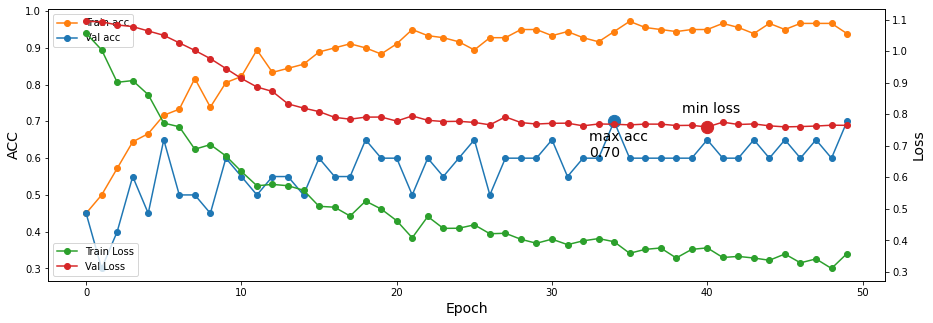

Training for fold 2 of 10...
Epoch 1/50
45/45 [==============================] - 17s 370ms/step - loss: 1.0647 - accuracy: 0.4333 - val_loss: 1.0944 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 1.0077 - accuracy: 0.4833 - val_loss: 1.0894 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 172ms/step - loss: 0.9306 - accuracy: 0.5611 - val_loss: 1.0883 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 175ms/step - loss: 0.8955 - accuracy: 0.5667 - val_loss: 1.0851 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8199 - accuracy: 0.6722 - val_loss: 1.0771 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 172ms/step - loss: 0.7877 - accuracy: 0.6333 - val_loss: 1.0720 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7580 - accuracy: 0.7944 - val_loss: 1.0667

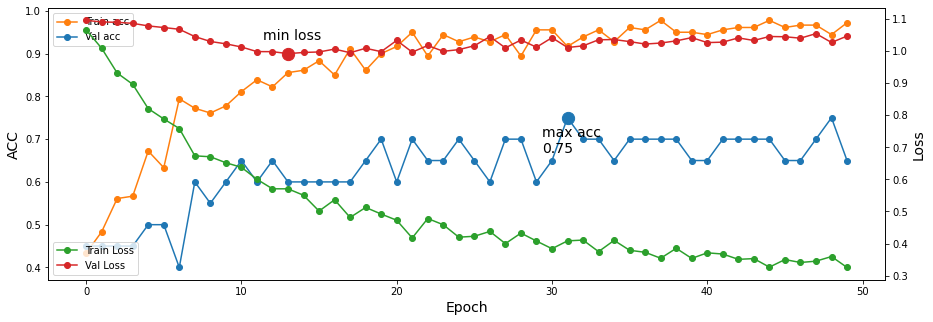

Training for fold 3 of 10...
Epoch 1/50
45/45 [==============================] - 17s 367ms/step - loss: 1.0648 - accuracy: 0.4722 - val_loss: 1.0906 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9659 - accuracy: 0.4778 - val_loss: 1.0885 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8842 - accuracy: 0.6278 - val_loss: 1.0820 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8091 - accuracy: 0.7056 - val_loss: 1.0619 - val_accuracy: 0.6000
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7644 - accuracy: 0.6889 - val_loss: 1.0472 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6703 - accuracy: 0.7778 - val_loss: 1.0260 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 8s 172ms/step - loss: 0.6842 - accuracy: 0.7833 - val_loss: 1.0201

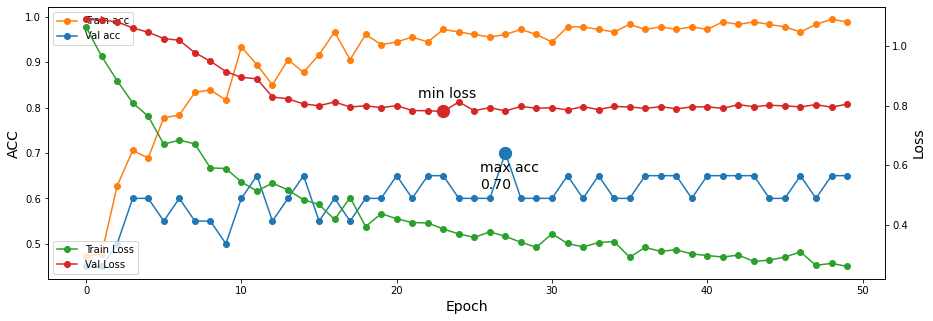

Training for fold 4 of 10...
Epoch 1/50
45/45 [==============================] - 17s 372ms/step - loss: 1.0452 - accuracy: 0.4556 - val_loss: 1.0948 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9450 - accuracy: 0.5167 - val_loss: 1.0928 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9043 - accuracy: 0.5722 - val_loss: 1.0890 - val_accuracy: 0.3500
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8181 - accuracy: 0.7000 - val_loss: 1.0819 - val_accuracy: 0.4000
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7946 - accuracy: 0.7111 - val_loss: 1.0758 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7215 - accuracy: 0.7278 - val_loss: 1.0609 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7243 - accuracy: 0.7444 - val_loss: 1.0458

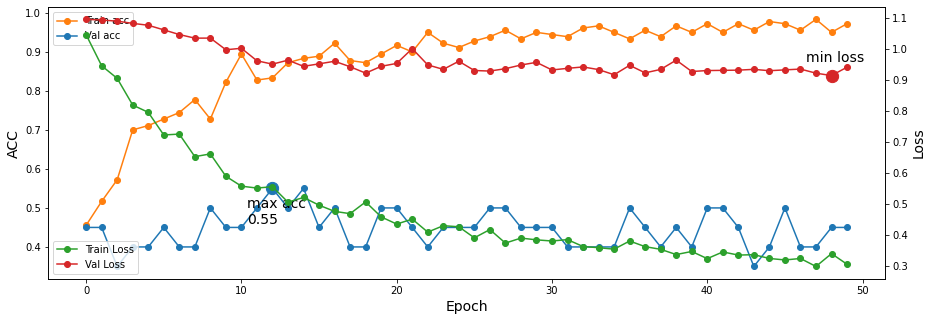

Training for fold 5 of 10...
Epoch 1/50
45/45 [==============================] - 16s 366ms/step - loss: 1.0438 - accuracy: 0.4444 - val_loss: 1.0917 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9842 - accuracy: 0.5389 - val_loss: 1.0912 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9022 - accuracy: 0.6167 - val_loss: 1.0867 - val_accuracy: 0.6500
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8501 - accuracy: 0.6611 - val_loss: 1.0740 - val_accuracy: 0.6000
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8139 - accuracy: 0.6889 - val_loss: 1.0557 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7071 - accuracy: 0.7278 - val_loss: 1.0430 - val_accuracy: 0.7000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7091 - accuracy: 0.7667 - val_loss: 1.0134

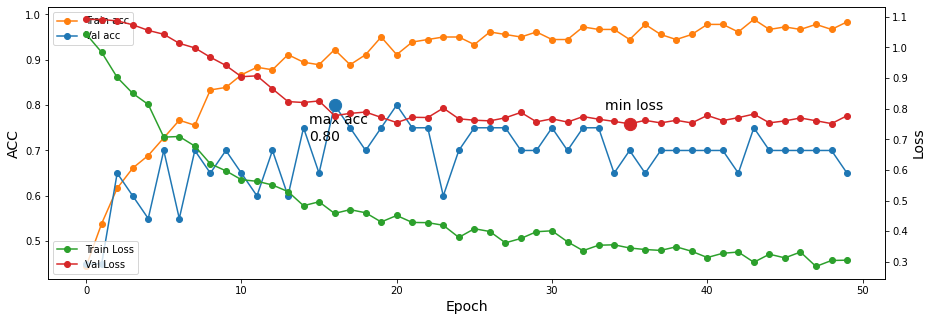

Training for fold 6 of 10...
Epoch 1/50
45/45 [==============================] - 15s 343ms/step - loss: 1.0608 - accuracy: 0.5056 - val_loss: 1.0902 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 1.0156 - accuracy: 0.4833 - val_loss: 1.0785 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9442 - accuracy: 0.6111 - val_loss: 1.0740 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8853 - accuracy: 0.5611 - val_loss: 1.0503 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 177ms/step - loss: 0.8168 - accuracy: 0.6944 - val_loss: 1.0378 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7599 - accuracy: 0.6556 - val_loss: 1.0145 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7523 - accuracy: 0.7722 - val_loss: 0.9923

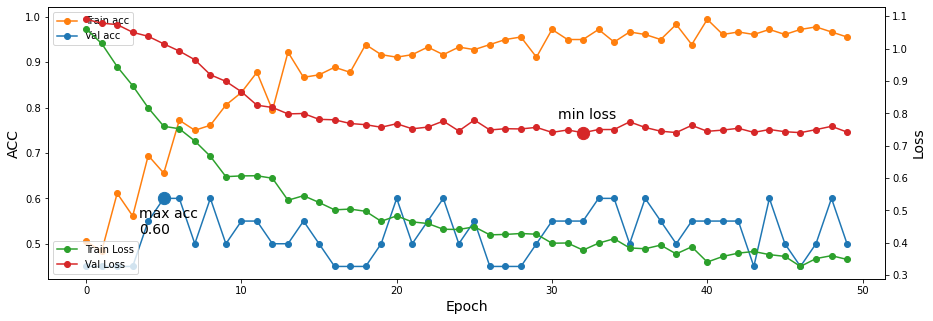

Training for fold 7 of 10...
Epoch 1/50
45/45 [==============================] - 16s 347ms/step - loss: 1.1084 - accuracy: 0.4167 - val_loss: 1.0913 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9953 - accuracy: 0.5167 - val_loss: 1.0884 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9157 - accuracy: 0.5611 - val_loss: 1.0800 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8545 - accuracy: 0.6222 - val_loss: 1.0735 - val_accuracy: 0.3500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8081 - accuracy: 0.6333 - val_loss: 1.0553 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7510 - accuracy: 0.7556 - val_loss: 1.0465 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6786 - accuracy: 0.8278 - val_loss: 1.0150

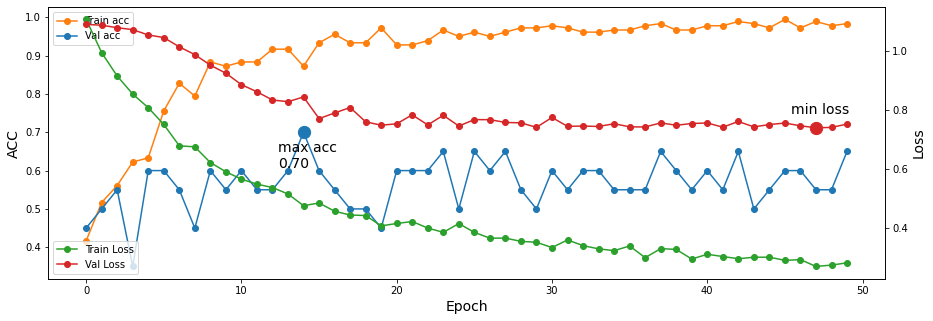

Training for fold 8 of 10...
Epoch 1/50
45/45 [==============================] - 16s 346ms/step - loss: 1.0709 - accuracy: 0.4444 - val_loss: 1.0948 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 1.0179 - accuracy: 0.4833 - val_loss: 1.0966 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9936 - accuracy: 0.4444 - val_loss: 1.0955 - val_accuracy: 0.3500
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9355 - accuracy: 0.5889 - val_loss: 1.0917 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8788 - accuracy: 0.5667 - val_loss: 1.0887 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9006 - accuracy: 0.6444 - val_loss: 1.0856 - val_accuracy: 0.3000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8087 - accuracy: 0.6667 - val_loss: 1.0752

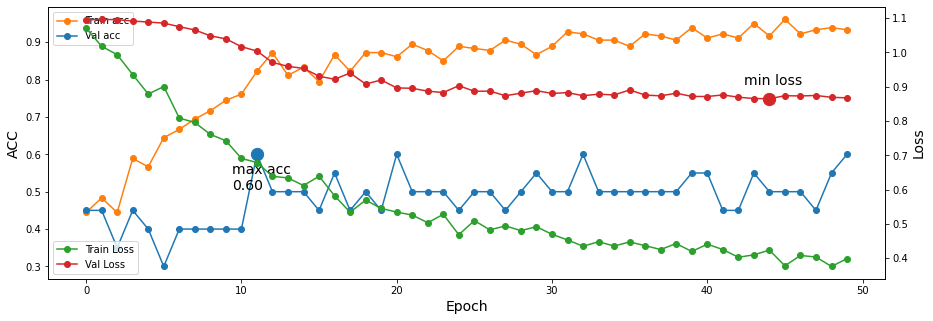

Training for fold 9 of 10...
Epoch 1/50
45/45 [==============================] - 17s 372ms/step - loss: 1.0725 - accuracy: 0.3889 - val_loss: 1.0976 - val_accuracy: 0.3000
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9537 - accuracy: 0.5167 - val_loss: 1.0932 - val_accuracy: 0.4000
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9197 - accuracy: 0.5778 - val_loss: 1.0873 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8779 - accuracy: 0.5833 - val_loss: 1.0818 - val_accuracy: 0.3000
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8360 - accuracy: 0.6944 - val_loss: 1.0650 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7449 - accuracy: 0.7389 - val_loss: 1.0408 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 8s 172ms/step - loss: 0.6901 - accuracy: 0.7833 - val_loss: 1.0237

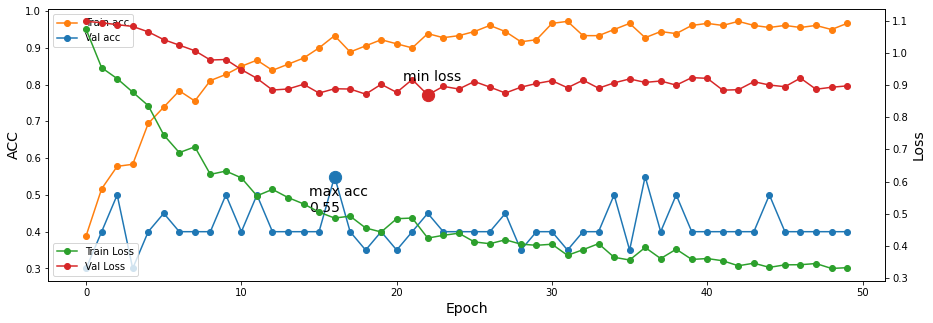

Training for fold 10 of 10...
Epoch 1/50
45/45 [==============================] - 17s 373ms/step - loss: 1.0972 - accuracy: 0.4000 - val_loss: 1.0931 - val_accuracy: 0.4211
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9535 - accuracy: 0.5278 - val_loss: 1.0879 - val_accuracy: 0.5263
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8864 - accuracy: 0.6056 - val_loss: 1.0789 - val_accuracy: 0.5263
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8453 - accuracy: 0.6556 - val_loss: 1.0723 - val_accuracy: 0.5789
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7649 - accuracy: 0.7000 - val_loss: 1.0554 - val_accuracy: 0.7368
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6896 - accuracy: 0.7222 - val_loss: 1.0352 - val_accuracy: 0.7895
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6472 - accuracy: 0.8222 - val_loss: 1.002

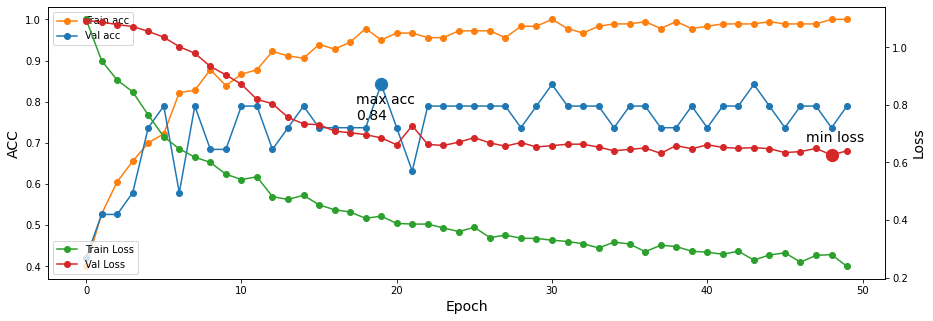

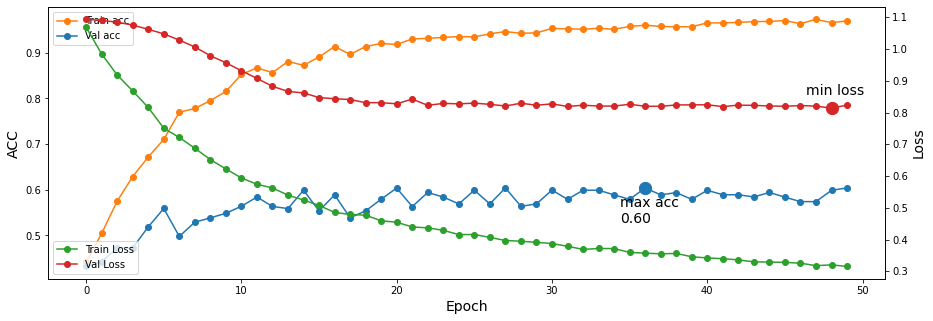

--------------------------------------------------------------------------------
Results per fold
--------------------------------------------------------------------------------
> Fold 1 - loss: 0.358699768781662 - accuracy: 0.9388889074325562 - val_loss.: 0.7649837136268616 - val_accuracy: 0.699999988079071
--------------------------------------------------------------------------------
> Fold 2 - loss: 0.32592588663101196 - accuracy: 0.9722222089767456 - val_loss.: 1.0454949140548706 - val_accuracy: 0.6499999761581421
--------------------------------------------------------------------------------
> Fold 3 - loss: 0.25889965891838074 - accuracy: 0.9888888597488403 - val_loss.: 0.8052518963813782 - val_accuracy: 0.6499999761581421
--------------------------------------------------------------------------------
> Fold 4 - loss: 0.3040378987789154 - accuracy: 0.9722222089767456 - val_loss.: 0.9404106140136719 - val_accuracy: 0.44999998807907104
-----------------------------------------

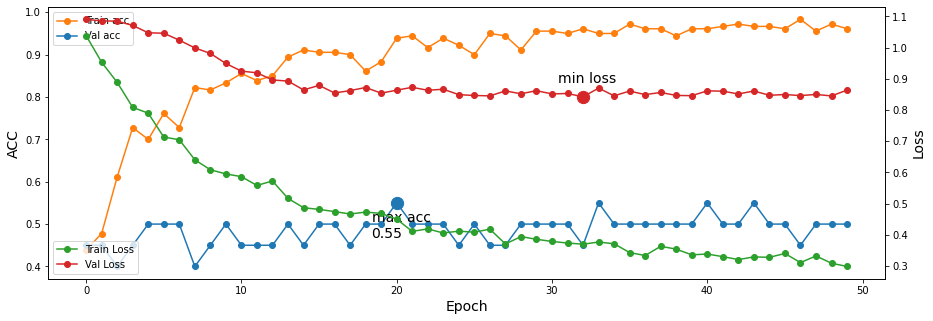

Training for fold 2 of 10...
Epoch 1/50
45/45 [==============================] - 16s 365ms/step - loss: 1.0492 - accuracy: 0.4833 - val_loss: 1.0935 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9921 - accuracy: 0.4556 - val_loss: 1.0912 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8916 - accuracy: 0.6167 - val_loss: 1.0878 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8364 - accuracy: 0.6667 - val_loss: 1.0766 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7680 - accuracy: 0.6889 - val_loss: 1.0672 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7565 - accuracy: 0.7500 - val_loss: 1.0598 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6668 - accuracy: 0.7778 - val_loss: 1.0492

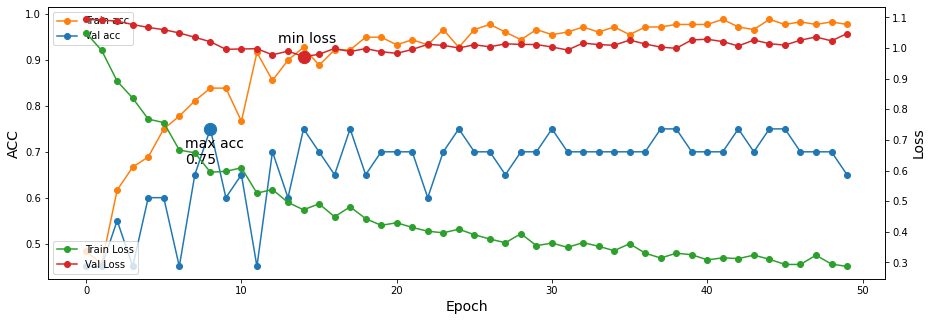

Training for fold 3 of 10...
Epoch 1/50
45/45 [==============================] - 17s 368ms/step - loss: 1.0372 - accuracy: 0.4833 - val_loss: 1.0909 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9685 - accuracy: 0.5556 - val_loss: 1.0837 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9103 - accuracy: 0.6333 - val_loss: 1.0711 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 8s 175ms/step - loss: 0.8501 - accuracy: 0.6500 - val_loss: 1.0603 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7914 - accuracy: 0.7056 - val_loss: 1.0434 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7321 - accuracy: 0.7667 - val_loss: 1.0255 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7136 - accuracy: 0.7278 - val_loss: 0.9940

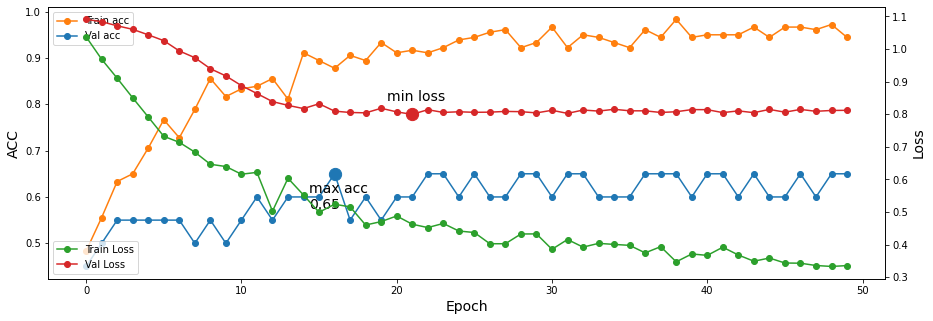

Training for fold 4 of 10...
Epoch 1/50
45/45 [==============================] - 17s 367ms/step - loss: 1.0848 - accuracy: 0.4167 - val_loss: 1.0943 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 1.0071 - accuracy: 0.4889 - val_loss: 1.0873 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8838 - accuracy: 0.6611 - val_loss: 1.0806 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 8s 181ms/step - loss: 0.8157 - accuracy: 0.6667 - val_loss: 1.0725 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8133 - accuracy: 0.6722 - val_loss: 1.0642 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7289 - accuracy: 0.7000 - val_loss: 1.0529 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7074 - accuracy: 0.7667 - val_loss: 1.0397

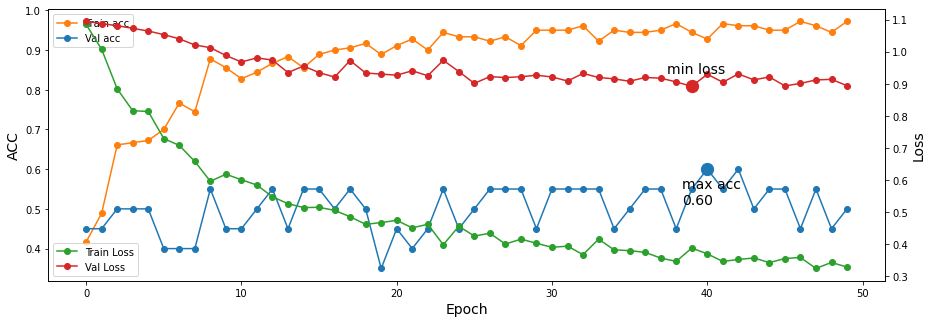

Training for fold 5 of 10...
Epoch 1/50
45/45 [==============================] - 17s 368ms/step - loss: 1.0325 - accuracy: 0.5111 - val_loss: 1.0937 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9832 - accuracy: 0.5111 - val_loss: 1.0931 - val_accuracy: 0.7000
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9210 - accuracy: 0.5389 - val_loss: 1.0851 - val_accuracy: 0.6000
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8556 - accuracy: 0.6278 - val_loss: 1.0811 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7770 - accuracy: 0.6389 - val_loss: 1.0600 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7347 - accuracy: 0.8056 - val_loss: 1.0374 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7034 - accuracy: 0.6778 - val_loss: 1.0166

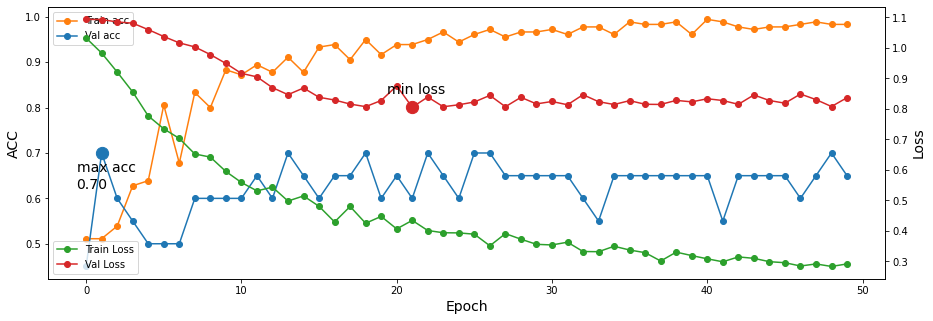

Training for fold 6 of 10...
Epoch 1/50
45/45 [==============================] - 16s 366ms/step - loss: 1.0382 - accuracy: 0.4611 - val_loss: 1.0883 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9184 - accuracy: 0.5500 - val_loss: 1.0839 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8843 - accuracy: 0.6333 - val_loss: 1.0795 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7810 - accuracy: 0.7333 - val_loss: 1.0580 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7306 - accuracy: 0.7556 - val_loss: 1.0381 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7265 - accuracy: 0.7222 - val_loss: 1.0206 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6836 - accuracy: 0.7556 - val_loss: 0.9903

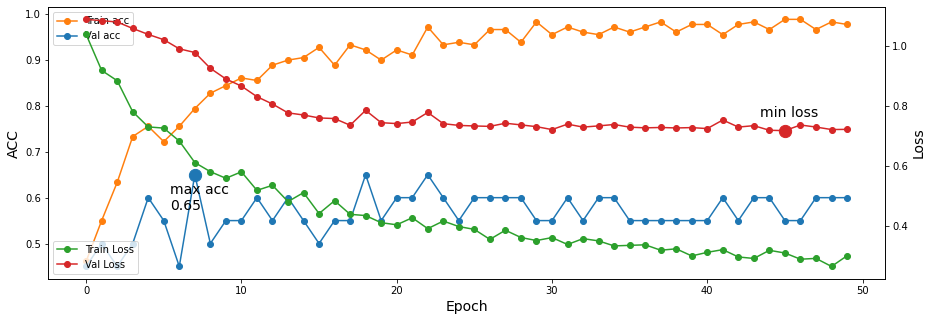

Training for fold 7 of 10...
Epoch 1/50
45/45 [==============================] - 17s 371ms/step - loss: 1.0319 - accuracy: 0.4833 - val_loss: 1.0916 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9472 - accuracy: 0.5444 - val_loss: 1.0829 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8598 - accuracy: 0.6056 - val_loss: 1.0766 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8460 - accuracy: 0.6389 - val_loss: 1.0669 - val_accuracy: 0.6500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7645 - accuracy: 0.6944 - val_loss: 1.0425 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7129 - accuracy: 0.7444 - val_loss: 1.0298 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6531 - accuracy: 0.8389 - val_loss: 0.9961

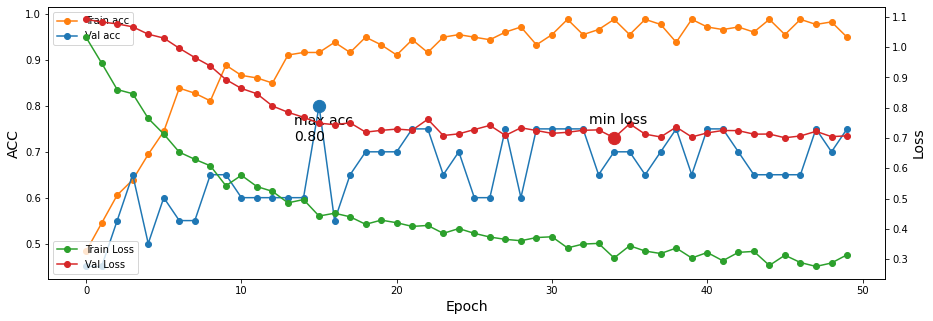

Training for fold 8 of 10...
Epoch 1/50
45/45 [==============================] - 17s 380ms/step - loss: 1.0379 - accuracy: 0.4444 - val_loss: 1.0954 - val_accuracy: 0.2500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9504 - accuracy: 0.5444 - val_loss: 1.0893 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8732 - accuracy: 0.6500 - val_loss: 1.0796 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8279 - accuracy: 0.6778 - val_loss: 1.0777 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7549 - accuracy: 0.7722 - val_loss: 1.0725 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6811 - accuracy: 0.7944 - val_loss: 1.0507 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6911 - accuracy: 0.7611 - val_loss: 1.0403

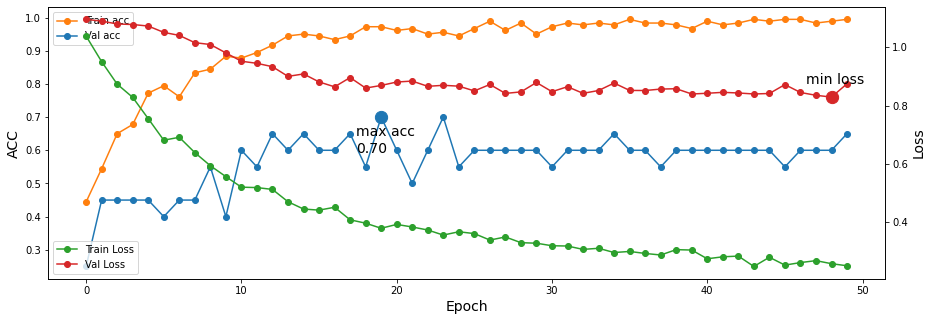

Training for fold 9 of 10...
Epoch 1/50
45/45 [==============================] - 17s 367ms/step - loss: 1.0653 - accuracy: 0.4278 - val_loss: 1.0950 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9202 - accuracy: 0.5444 - val_loss: 1.0887 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9138 - accuracy: 0.6167 - val_loss: 1.0881 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8157 - accuracy: 0.6111 - val_loss: 1.0816 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8092 - accuracy: 0.6778 - val_loss: 1.0694 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7129 - accuracy: 0.8111 - val_loss: 1.0529 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7039 - accuracy: 0.7278 - val_loss: 1.0362

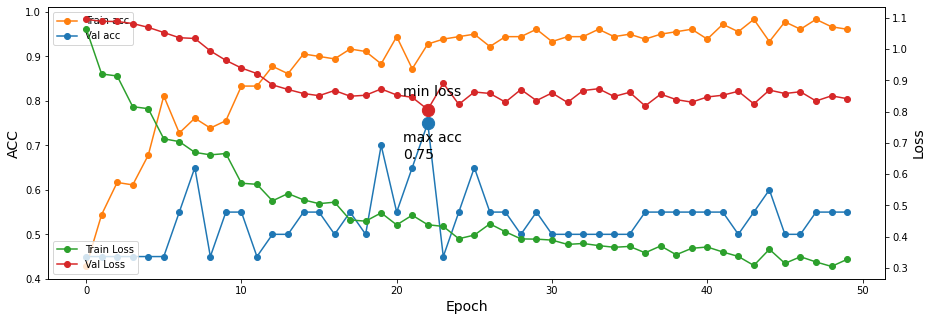

Training for fold 10 of 10...
Epoch 1/50
45/45 [==============================] - 17s 371ms/step - loss: 1.0608 - accuracy: 0.4389 - val_loss: 1.0924 - val_accuracy: 0.4211
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9811 - accuracy: 0.5111 - val_loss: 1.0846 - val_accuracy: 0.4211
Epoch 3/50
45/45 [==============================] - 8s 172ms/step - loss: 0.8950 - accuracy: 0.5500 - val_loss: 1.0761 - val_accuracy: 0.4211
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8305 - accuracy: 0.7222 - val_loss: 1.0628 - val_accuracy: 0.4737
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7602 - accuracy: 0.6889 - val_loss: 1.0430 - val_accuracy: 0.4737
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7443 - accuracy: 0.7833 - val_loss: 1.0190 - val_accuracy: 0.6842
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6953 - accuracy: 0.7667 - val_loss: 0.992

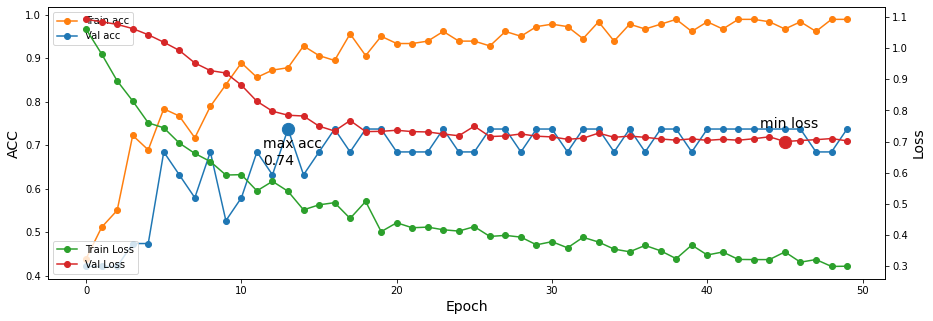

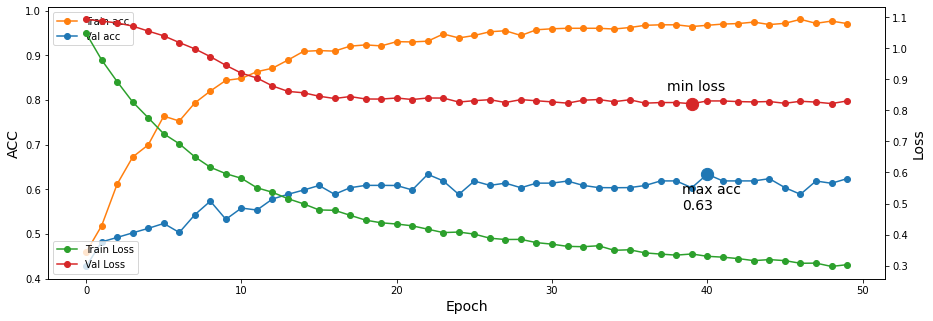

--------------------------------------------------------------------------------
Results per fold
--------------------------------------------------------------------------------
> Fold 1 - loss: 0.2990034222602844 - accuracy: 0.9611111283302307 - val_loss.: 0.8637978434562683 - val_accuracy: 0.5
--------------------------------------------------------------------------------
> Fold 2 - loss: 0.2868293523788452 - accuracy: 0.9777777791023254 - val_loss.: 1.0471217632293701 - val_accuracy: 0.6499999761581421
--------------------------------------------------------------------------------
> Fold 3 - loss: 0.3353552520275116 - accuracy: 0.9444444179534912 - val_loss.: 0.8117562532424927 - val_accuracy: 0.6499999761581421
--------------------------------------------------------------------------------
> Fold 4 - loss: 0.3279203772544861 - accuracy: 0.9722222089767456 - val_loss.: 0.8935793042182922 - val_accuracy: 0.5
------------------------------------------------------------------------

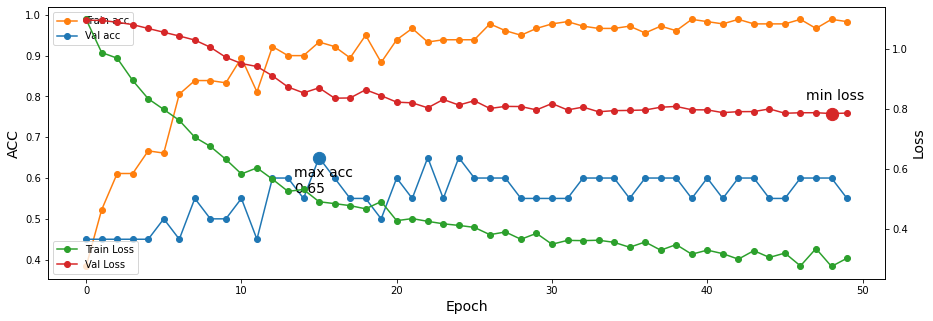

Training for fold 2 of 10...
Epoch 1/50
45/45 [==============================] - 16s 358ms/step - loss: 1.0617 - accuracy: 0.3944 - val_loss: 1.0961 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9713 - accuracy: 0.5111 - val_loss: 1.0934 - val_accuracy: 0.5500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9263 - accuracy: 0.5667 - val_loss: 1.0882 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8399 - accuracy: 0.6167 - val_loss: 1.0875 - val_accuracy: 0.4000
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7880 - accuracy: 0.7556 - val_loss: 1.0719 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7879 - accuracy: 0.6333 - val_loss: 1.0794 - val_accuracy: 0.4500
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7108 - accuracy: 0.7667 - val_loss: 1.0603

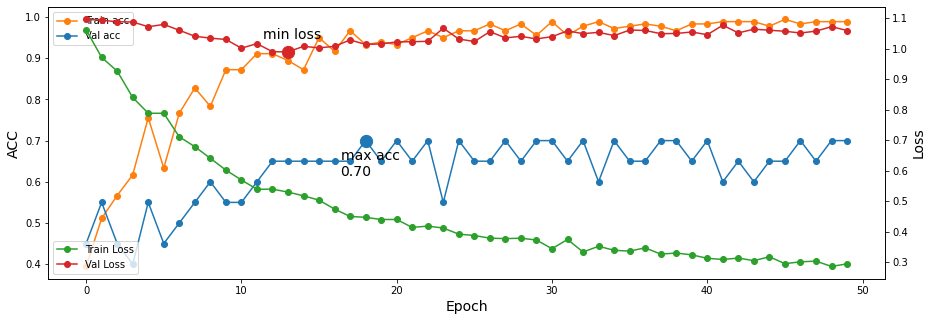

Training for fold 3 of 10...
Epoch 1/50
45/45 [==============================] - 17s 369ms/step - loss: 1.0615 - accuracy: 0.4333 - val_loss: 1.0940 - val_accuracy: 0.5000
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9861 - accuracy: 0.4722 - val_loss: 1.0874 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8768 - accuracy: 0.5667 - val_loss: 1.0776 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9172 - accuracy: 0.6278 - val_loss: 1.0741 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7881 - accuracy: 0.7167 - val_loss: 1.0625 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7536 - accuracy: 0.7056 - val_loss: 1.0417 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7317 - accuracy: 0.8000 - val_loss: 1.0254

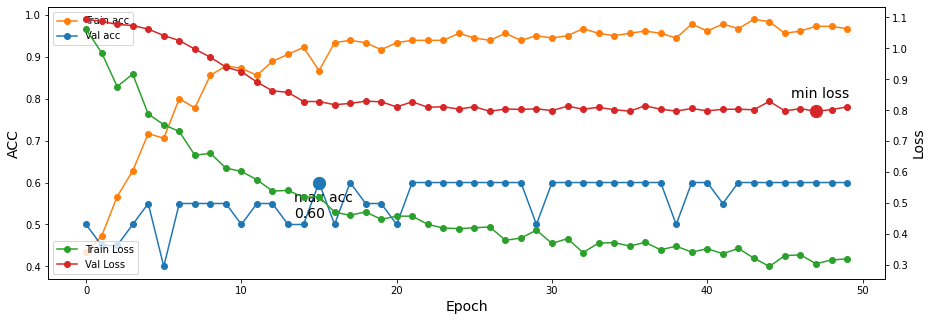

Training for fold 4 of 10...
Epoch 1/50
45/45 [==============================] - 16s 349ms/step - loss: 1.0691 - accuracy: 0.4889 - val_loss: 1.0920 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9326 - accuracy: 0.5167 - val_loss: 1.0843 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8708 - accuracy: 0.6278 - val_loss: 1.0839 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8281 - accuracy: 0.6833 - val_loss: 1.0787 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7536 - accuracy: 0.7389 - val_loss: 1.0653 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7229 - accuracy: 0.7722 - val_loss: 1.0507 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6632 - accuracy: 0.8000 - val_loss: 1.0378

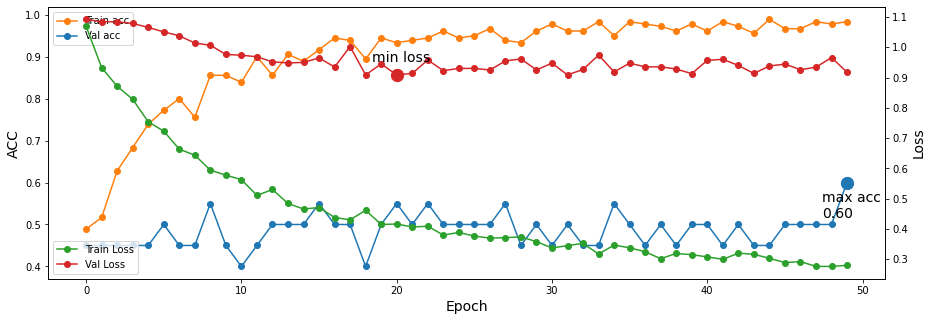

Training for fold 5 of 10...
Epoch 1/50
45/45 [==============================] - 17s 367ms/step - loss: 1.0470 - accuracy: 0.4611 - val_loss: 1.0925 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9836 - accuracy: 0.4889 - val_loss: 1.0897 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8904 - accuracy: 0.5500 - val_loss: 1.0837 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8734 - accuracy: 0.5778 - val_loss: 1.0759 - val_accuracy: 0.6000
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8014 - accuracy: 0.7389 - val_loss: 1.0531 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7618 - accuracy: 0.7222 - val_loss: 1.0387 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7301 - accuracy: 0.7222 - val_loss: 1.0265

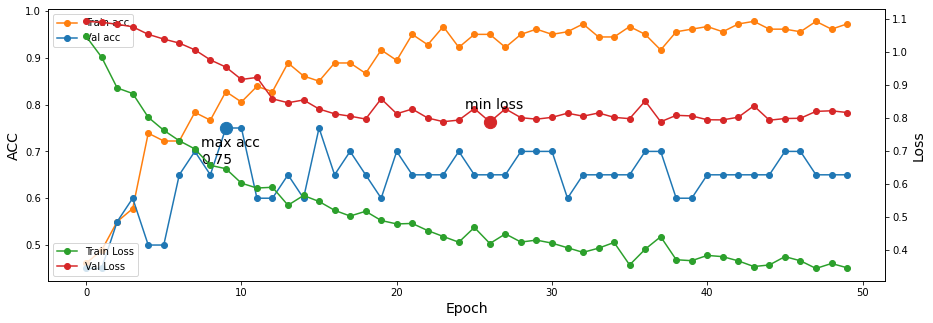

Training for fold 6 of 10...
Epoch 1/50
45/45 [==============================] - 17s 367ms/step - loss: 1.0666 - accuracy: 0.4222 - val_loss: 1.0947 - val_accuracy: 0.5000
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9674 - accuracy: 0.5056 - val_loss: 1.0895 - val_accuracy: 0.6000
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8576 - accuracy: 0.6111 - val_loss: 1.0749 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8167 - accuracy: 0.6778 - val_loss: 1.0631 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7663 - accuracy: 0.7167 - val_loss: 1.0479 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7479 - accuracy: 0.7222 - val_loss: 1.0238 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6862 - accuracy: 0.8556 - val_loss: 1.0005

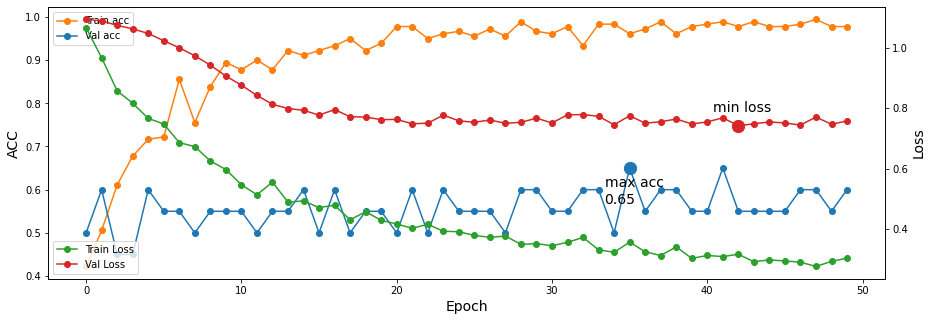

Training for fold 7 of 10...
Epoch 1/50
45/45 [==============================] - 17s 382ms/step - loss: 1.0469 - accuracy: 0.4722 - val_loss: 1.0950 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 1.0198 - accuracy: 0.4611 - val_loss: 1.0923 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9739 - accuracy: 0.4778 - val_loss: 1.0917 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9447 - accuracy: 0.5889 - val_loss: 1.0855 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8973 - accuracy: 0.5444 - val_loss: 1.0768 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8573 - accuracy: 0.6889 - val_loss: 1.0687 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8115 - accuracy: 0.8111 - val_loss: 1.0503

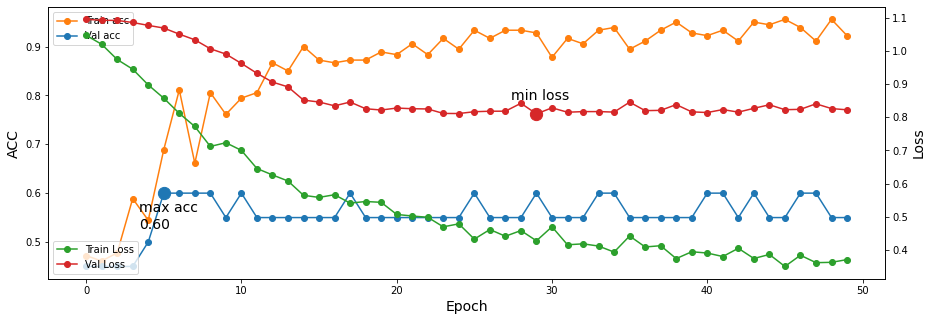

Training for fold 8 of 10...
Epoch 1/50
45/45 [==============================] - 17s 368ms/step - loss: 1.0461 - accuracy: 0.4611 - val_loss: 1.0966 - val_accuracy: 0.4000
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9806 - accuracy: 0.5389 - val_loss: 1.0911 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9298 - accuracy: 0.5944 - val_loss: 1.0881 - val_accuracy: 0.4000
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8443 - accuracy: 0.6333 - val_loss: 1.0818 - val_accuracy: 0.4000
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7987 - accuracy: 0.6722 - val_loss: 1.0729 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7267 - accuracy: 0.7667 - val_loss: 1.0556 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7092 - accuracy: 0.7444 - val_loss: 1.0506

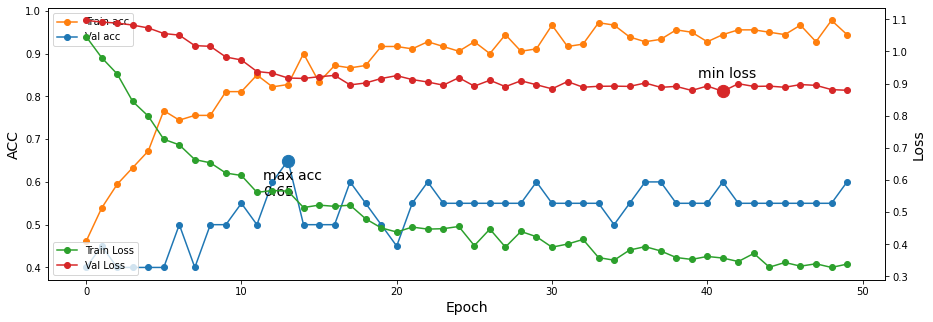

Training for fold 9 of 10...
Epoch 1/50
45/45 [==============================] - 17s 370ms/step - loss: 1.0602 - accuracy: 0.4222 - val_loss: 1.0915 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9456 - accuracy: 0.5222 - val_loss: 1.0881 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9252 - accuracy: 0.6222 - val_loss: 1.0837 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8336 - accuracy: 0.7111 - val_loss: 1.0790 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7923 - accuracy: 0.7167 - val_loss: 1.0596 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7681 - accuracy: 0.7056 - val_loss: 1.0546 - val_accuracy: 0.3500
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6875 - accuracy: 0.7944 - val_loss: 1.0282

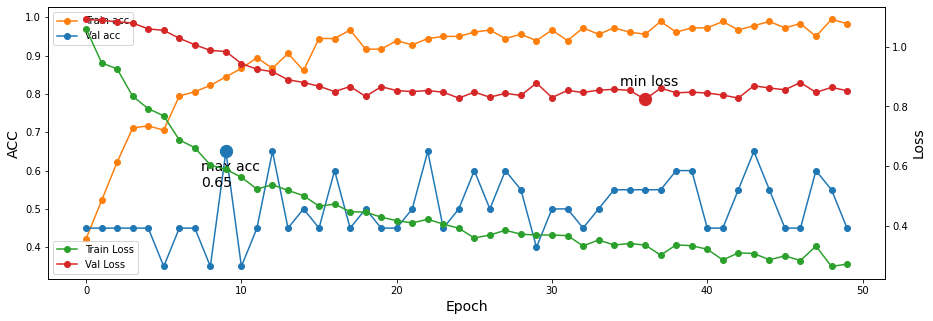

Training for fold 10 of 10...
Epoch 1/50
45/45 [==============================] - 17s 371ms/step - loss: 1.0103 - accuracy: 0.5000 - val_loss: 1.0921 - val_accuracy: 0.4211
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9863 - accuracy: 0.5000 - val_loss: 1.0885 - val_accuracy: 0.4211
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9127 - accuracy: 0.6222 - val_loss: 1.0807 - val_accuracy: 0.4211
Epoch 4/50
45/45 [==============================] - 8s 176ms/step - loss: 0.8245 - accuracy: 0.6444 - val_loss: 1.0719 - val_accuracy: 0.5789
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7979 - accuracy: 0.7111 - val_loss: 1.0599 - val_accuracy: 0.5789
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7363 - accuracy: 0.8000 - val_loss: 1.0354 - val_accuracy: 0.6316
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6690 - accuracy: 0.7889 - val_loss: 1.015

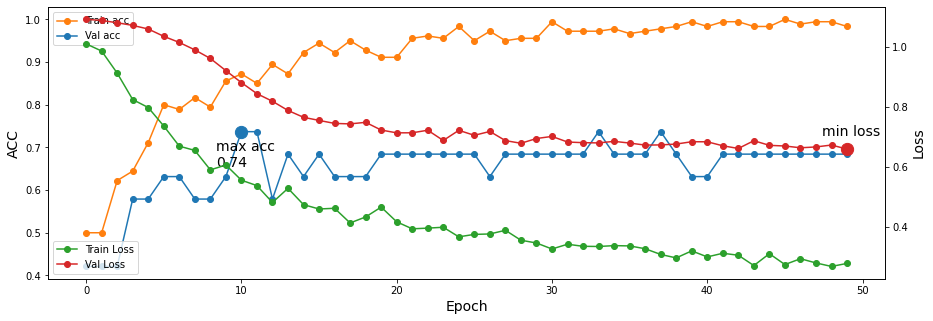

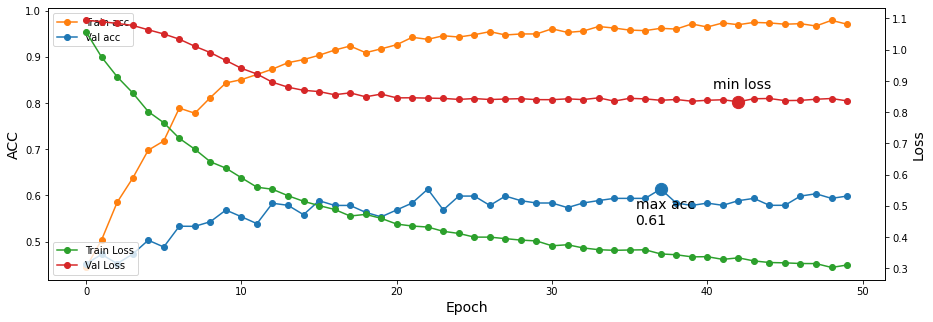

--------------------------------------------------------------------------------
Results per fold
--------------------------------------------------------------------------------
> Fold 1 - loss: 0.3021462857723236 - accuracy: 0.9833333492279053 - val_loss.: 0.785991370677948 - val_accuracy: 0.550000011920929
--------------------------------------------------------------------------------
> Fold 2 - loss: 0.29396602511405945 - accuracy: 0.9888888597488403 - val_loss.: 1.0594624280929565 - val_accuracy: 0.699999988079071
--------------------------------------------------------------------------------
> Fold 3 - loss: 0.3202354311943054 - accuracy: 0.9666666388511658 - val_loss.: 0.8110703229904175 - val_accuracy: 0.6000000238418579
--------------------------------------------------------------------------------
> Fold 4 - loss: 0.2797922194004059 - accuracy: 0.9833333492279053 - val_loss.: 0.9173910021781921 - val_accuracy: 0.6000000238418579
--------------------------------------------

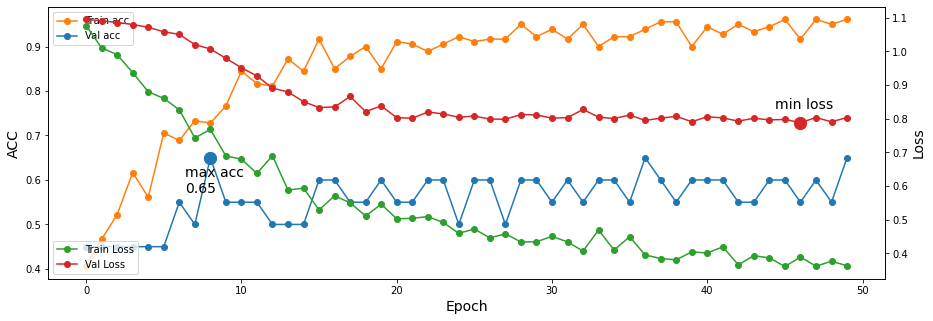

Training for fold 2 of 10...
Epoch 1/50
45/45 [==============================] - 17s 383ms/step - loss: 1.0705 - accuracy: 0.4389 - val_loss: 1.0934 - val_accuracy: 0.4000
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9730 - accuracy: 0.5444 - val_loss: 1.0889 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8981 - accuracy: 0.6222 - val_loss: 1.0827 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8137 - accuracy: 0.6167 - val_loss: 1.0768 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7486 - accuracy: 0.7056 - val_loss: 1.0599 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7510 - accuracy: 0.7278 - val_loss: 1.0542 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6948 - accuracy: 0.7667 - val_loss: 1.0409

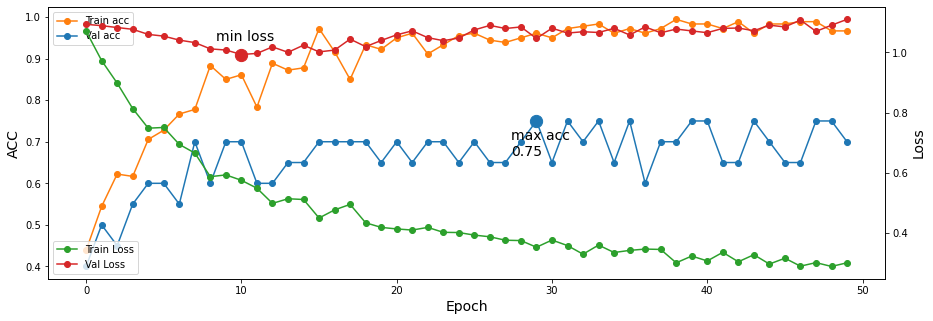

Training for fold 3 of 10...
Epoch 1/50
45/45 [==============================] - 16s 351ms/step - loss: 1.0504 - accuracy: 0.4500 - val_loss: 1.0914 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9603 - accuracy: 0.5111 - val_loss: 1.0880 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9307 - accuracy: 0.6278 - val_loss: 1.0816 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8361 - accuracy: 0.7111 - val_loss: 1.0668 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7741 - accuracy: 0.7000 - val_loss: 1.0599 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7470 - accuracy: 0.7722 - val_loss: 1.0429 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6956 - accuracy: 0.8333 - val_loss: 1.0201

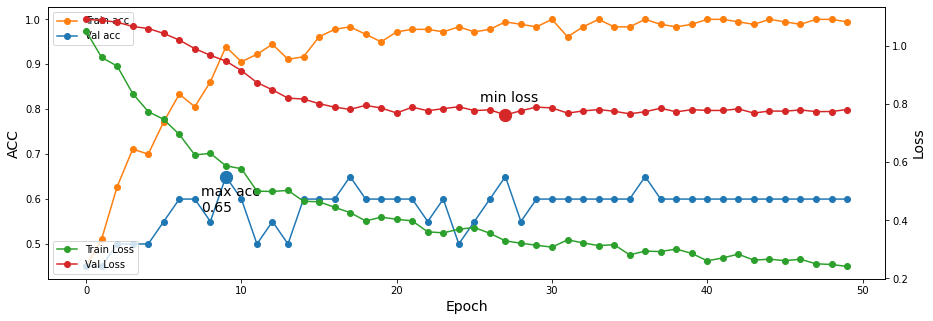

Training for fold 4 of 10...
Epoch 1/50
45/45 [==============================] - 16s 349ms/step - loss: 1.0247 - accuracy: 0.4944 - val_loss: 1.0935 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 1.0426 - accuracy: 0.4667 - val_loss: 1.0970 - val_accuracy: 0.3000
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9782 - accuracy: 0.4944 - val_loss: 1.0932 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9662 - accuracy: 0.5722 - val_loss: 1.0919 - val_accuracy: 0.4000
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9082 - accuracy: 0.5944 - val_loss: 1.0895 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8961 - accuracy: 0.6167 - val_loss: 1.0845 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8253 - accuracy: 0.6222 - val_loss: 1.0702

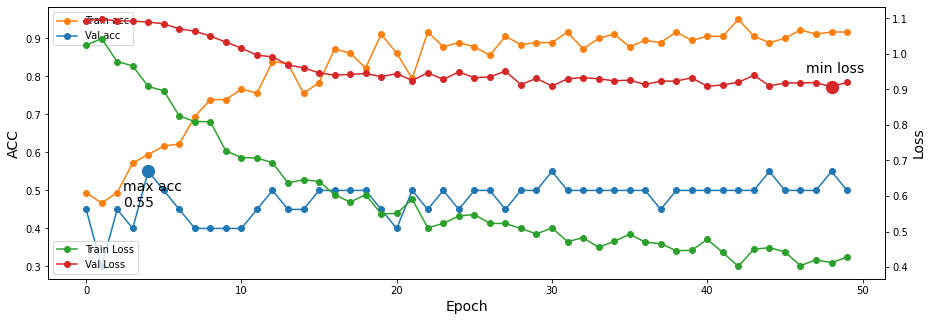

Training for fold 5 of 10...
Epoch 1/50
45/45 [==============================] - 17s 371ms/step - loss: 1.0655 - accuracy: 0.4389 - val_loss: 1.0930 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9801 - accuracy: 0.4667 - val_loss: 1.0905 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8747 - accuracy: 0.5833 - val_loss: 1.0755 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8774 - accuracy: 0.6444 - val_loss: 1.0792 - val_accuracy: 0.6500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7898 - accuracy: 0.6667 - val_loss: 1.0614 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7360 - accuracy: 0.6889 - val_loss: 1.0480 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6750 - accuracy: 0.8111 - val_loss: 1.0257

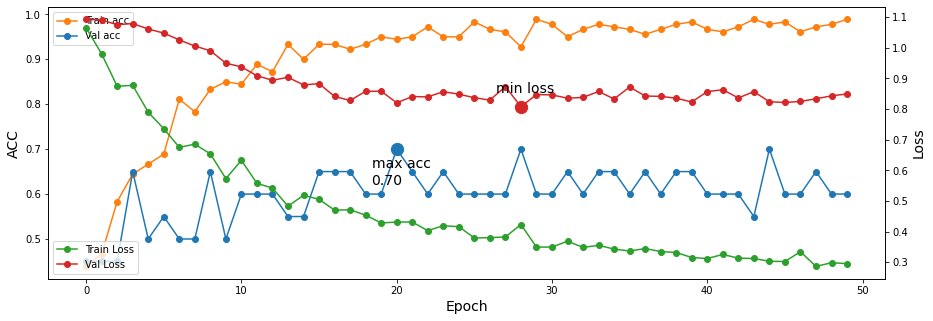

Training for fold 6 of 10...
Epoch 1/50
45/45 [==============================] - 17s 369ms/step - loss: 1.0168 - accuracy: 0.5056 - val_loss: 1.0898 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9584 - accuracy: 0.5556 - val_loss: 1.0822 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9153 - accuracy: 0.6056 - val_loss: 1.0746 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8309 - accuracy: 0.6611 - val_loss: 1.0700 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7877 - accuracy: 0.7056 - val_loss: 1.0473 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 176ms/step - loss: 0.7124 - accuracy: 0.7722 - val_loss: 1.0384 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7028 - accuracy: 0.7889 - val_loss: 1.0111

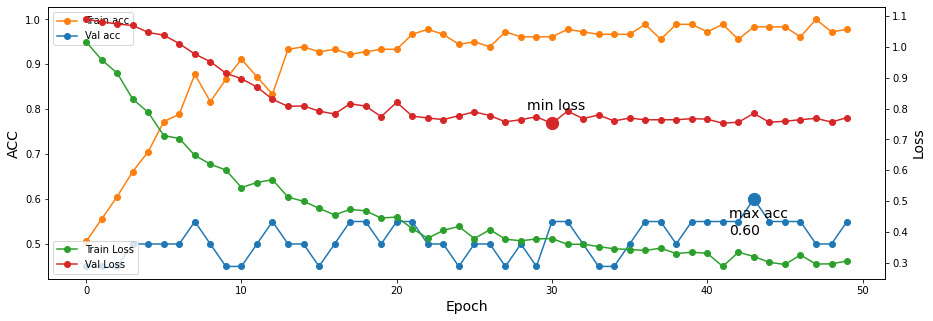

Training for fold 7 of 10...
Epoch 1/50
45/45 [==============================] - 16s 349ms/step - loss: 1.0564 - accuracy: 0.4889 - val_loss: 1.0921 - val_accuracy: 0.5000
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9583 - accuracy: 0.5611 - val_loss: 1.0892 - val_accuracy: 0.4000
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8826 - accuracy: 0.6111 - val_loss: 1.0768 - val_accuracy: 0.6000
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7839 - accuracy: 0.7000 - val_loss: 1.0575 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7657 - accuracy: 0.6833 - val_loss: 1.0480 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7531 - accuracy: 0.6667 - val_loss: 1.0306 - val_accuracy: 0.6000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6820 - accuracy: 0.7889 - val_loss: 0.9966

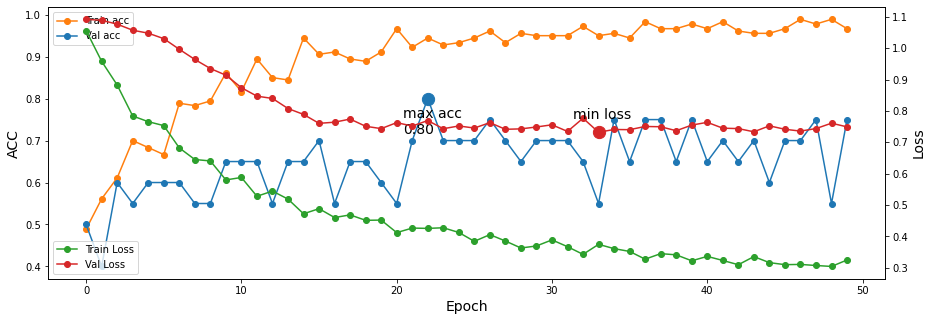

Training for fold 8 of 10...
Epoch 1/50
45/45 [==============================] - 17s 368ms/step - loss: 1.0433 - accuracy: 0.4389 - val_loss: 1.0938 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9921 - accuracy: 0.5056 - val_loss: 1.0891 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9355 - accuracy: 0.5278 - val_loss: 1.0831 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8820 - accuracy: 0.7000 - val_loss: 1.0855 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 9s 190ms/step - loss: 0.8531 - accuracy: 0.6111 - val_loss: 1.0706 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7980 - accuracy: 0.7222 - val_loss: 1.0572 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7316 - accuracy: 0.6944 - val_loss: 1.0398

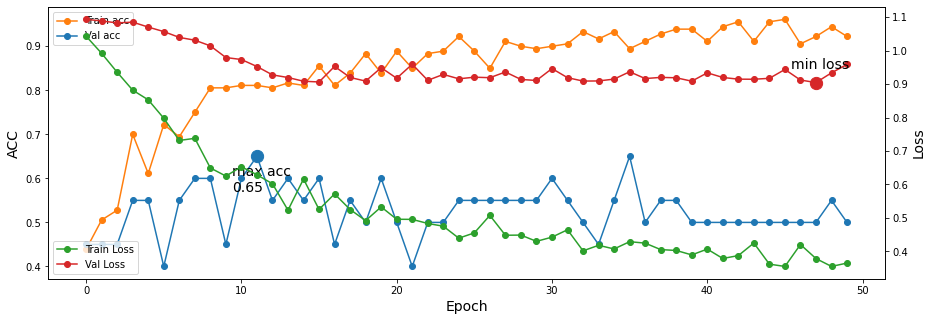

Training for fold 9 of 10...
Epoch 1/50
45/45 [==============================] - 17s 371ms/step - loss: 1.0549 - accuracy: 0.4667 - val_loss: 1.0935 - val_accuracy: 0.4000
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9538 - accuracy: 0.5500 - val_loss: 1.0844 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8975 - accuracy: 0.5722 - val_loss: 1.0797 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7991 - accuracy: 0.7000 - val_loss: 1.0644 - val_accuracy: 0.4000
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7345 - accuracy: 0.7000 - val_loss: 1.0521 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7355 - accuracy: 0.7500 - val_loss: 1.0470 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6407 - accuracy: 0.7833 - val_loss: 1.0161

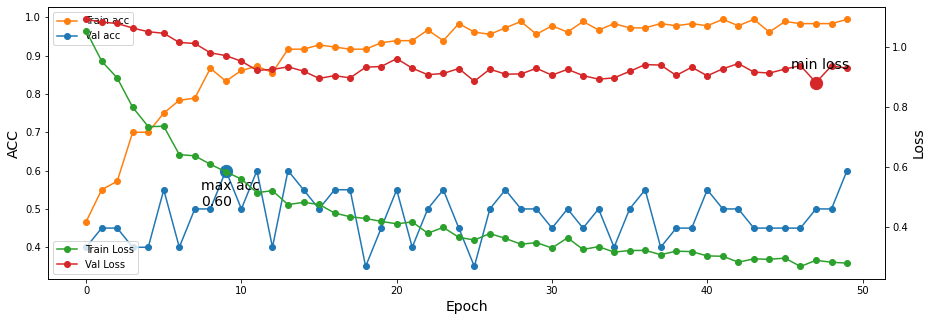

Training for fold 10 of 10...
Epoch 1/50
45/45 [==============================] - 17s 368ms/step - loss: 1.0771 - accuracy: 0.4111 - val_loss: 1.0931 - val_accuracy: 0.4211
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9869 - accuracy: 0.4944 - val_loss: 1.0907 - val_accuracy: 0.5263
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9023 - accuracy: 0.5833 - val_loss: 1.0816 - val_accuracy: 0.4737
Epoch 4/50
45/45 [==============================] - 8s 176ms/step - loss: 0.8685 - accuracy: 0.6389 - val_loss: 1.0711 - val_accuracy: 0.5263
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7811 - accuracy: 0.7222 - val_loss: 1.0585 - val_accuracy: 0.5789
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7761 - accuracy: 0.7111 - val_loss: 1.0423 - val_accuracy: 0.4737
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7010 - accuracy: 0.7722 - val_loss: 1.018

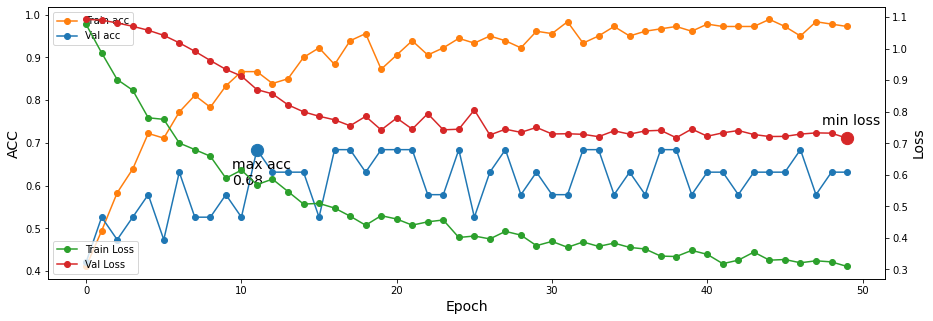

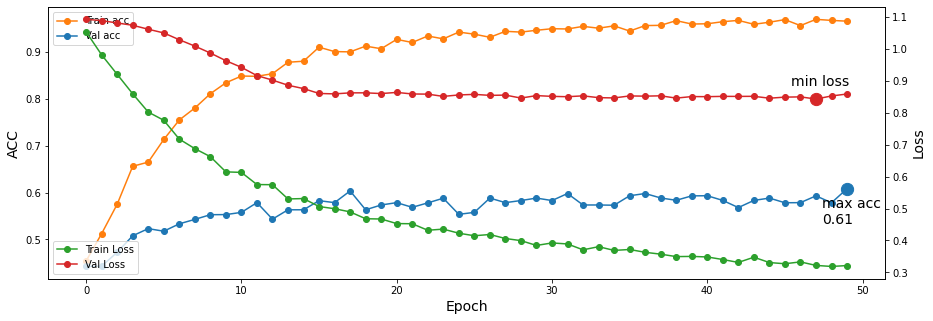

--------------------------------------------------------------------------------
Results per fold
--------------------------------------------------------------------------------
> Fold 1 - loss: 0.3635309934616089 - accuracy: 0.9611111283302307 - val_loss.: 0.8037205934524536 - val_accuracy: 0.6499999761581421
--------------------------------------------------------------------------------
> Fold 2 - loss: 0.30181220173835754 - accuracy: 0.9666666388511658 - val_loss.: 1.109863042831421 - val_accuracy: 0.699999988079071
--------------------------------------------------------------------------------
> Fold 3 - loss: 0.24141445755958557 - accuracy: 0.9944444298744202 - val_loss.: 0.7811794877052307 - val_accuracy: 0.6000000238418579
--------------------------------------------------------------------------------
> Fold 4 - loss: 0.42824938893318176 - accuracy: 0.9166666865348816 - val_loss.: 0.9197160005569458 - val_accuracy: 0.5
--------------------------------------------------------

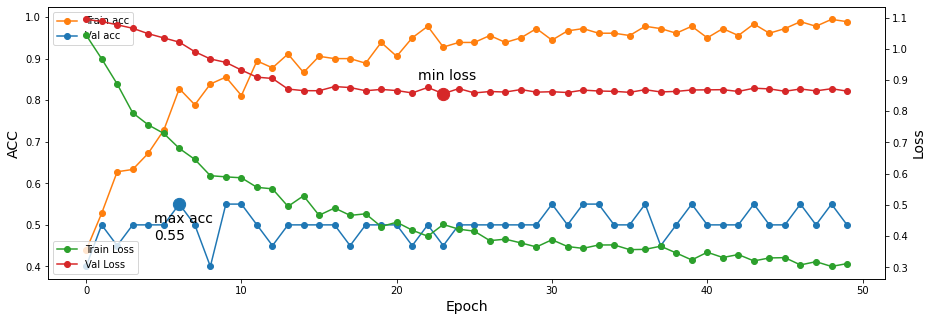

Training for fold 2 of 10...
Epoch 1/50
45/45 [==============================] - 17s 371ms/step - loss: 1.0464 - accuracy: 0.4667 - val_loss: 1.0965 - val_accuracy: 0.2500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9737 - accuracy: 0.5389 - val_loss: 1.0882 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 176ms/step - loss: 0.8719 - accuracy: 0.6333 - val_loss: 1.0845 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8046 - accuracy: 0.6278 - val_loss: 1.0817 - val_accuracy: 0.8000
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7746 - accuracy: 0.7056 - val_loss: 1.0629 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6993 - accuracy: 0.7611 - val_loss: 1.0506 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 8s 173ms/step - loss: 0.6527 - accuracy: 0.7889 - val_loss: 1.0316

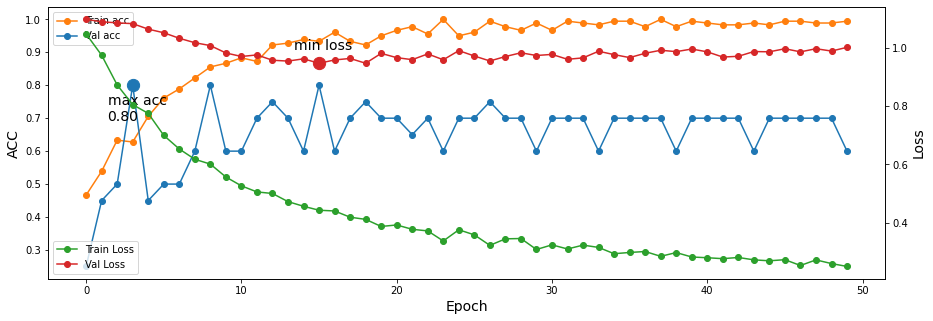

Training for fold 3 of 10...
Epoch 1/50
45/45 [==============================] - 17s 369ms/step - loss: 1.0777 - accuracy: 0.4278 - val_loss: 1.0908 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9393 - accuracy: 0.5333 - val_loss: 1.0846 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8698 - accuracy: 0.6389 - val_loss: 1.0676 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 8s 175ms/step - loss: 0.8479 - accuracy: 0.7000 - val_loss: 1.0563 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7439 - accuracy: 0.7222 - val_loss: 1.0311 - val_accuracy: 0.6500
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6784 - accuracy: 0.8111 - val_loss: 1.0090 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 8s 175ms/step - loss: 0.6754 - accuracy: 0.7889 - val_loss: 0.9719

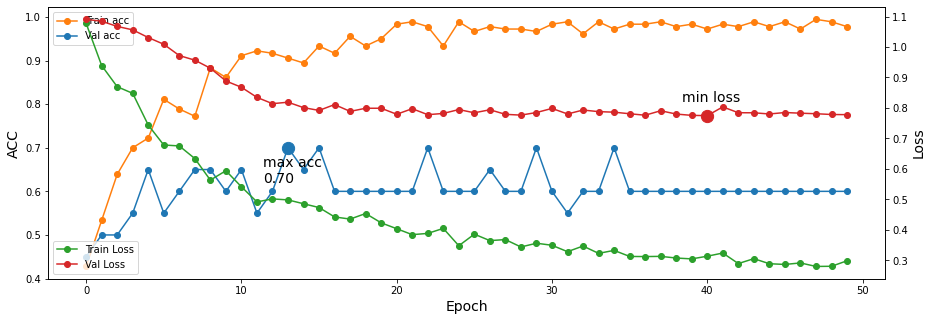

Training for fold 4 of 10...
Epoch 1/50
45/45 [==============================] - 16s 347ms/step - loss: 1.0955 - accuracy: 0.3833 - val_loss: 1.0970 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 1.0078 - accuracy: 0.4833 - val_loss: 1.0951 - val_accuracy: 0.4000
Epoch 3/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9021 - accuracy: 0.5889 - val_loss: 1.0903 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9295 - accuracy: 0.5444 - val_loss: 1.0916 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8531 - accuracy: 0.6667 - val_loss: 1.0810 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8270 - accuracy: 0.6556 - val_loss: 1.0737 - val_accuracy: 0.4000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7406 - accuracy: 0.7000 - val_loss: 1.0651

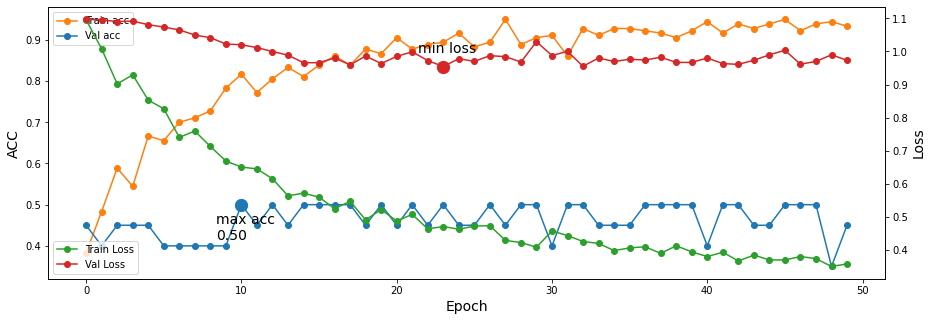

Training for fold 5 of 10...
Epoch 1/50
45/45 [==============================] - 17s 368ms/step - loss: 1.0701 - accuracy: 0.4389 - val_loss: 1.0926 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9897 - accuracy: 0.4722 - val_loss: 1.0894 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8485 - accuracy: 0.6333 - val_loss: 1.0817 - val_accuracy: 0.5500
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8028 - accuracy: 0.7000 - val_loss: 1.0692 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7561 - accuracy: 0.7167 - val_loss: 1.0525 - val_accuracy: 0.6500
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7662 - accuracy: 0.7333 - val_loss: 1.0313 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6676 - accuracy: 0.8056 - val_loss: 1.0117

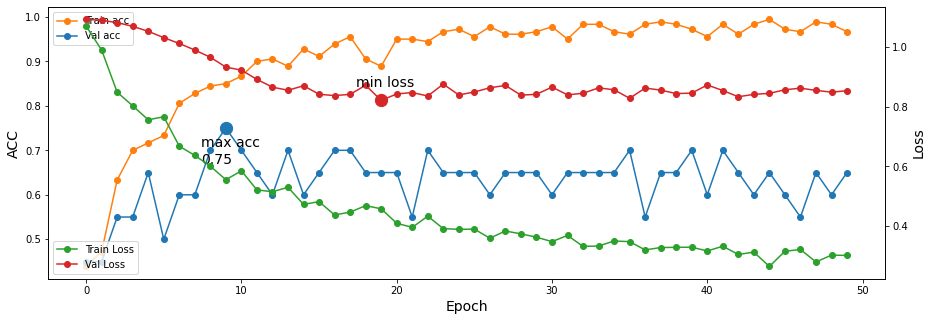

Training for fold 6 of 10...
Epoch 1/50
45/45 [==============================] - 17s 370ms/step - loss: 1.1316 - accuracy: 0.3167 - val_loss: 1.0916 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9485 - accuracy: 0.4889 - val_loss: 1.0881 - val_accuracy: 0.5500
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8723 - accuracy: 0.5944 - val_loss: 1.0769 - val_accuracy: 0.6500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8119 - accuracy: 0.7167 - val_loss: 1.0592 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7773 - accuracy: 0.7167 - val_loss: 1.0349 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7487 - accuracy: 0.7111 - val_loss: 1.0171 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7035 - accuracy: 0.7889 - val_loss: 0.9875

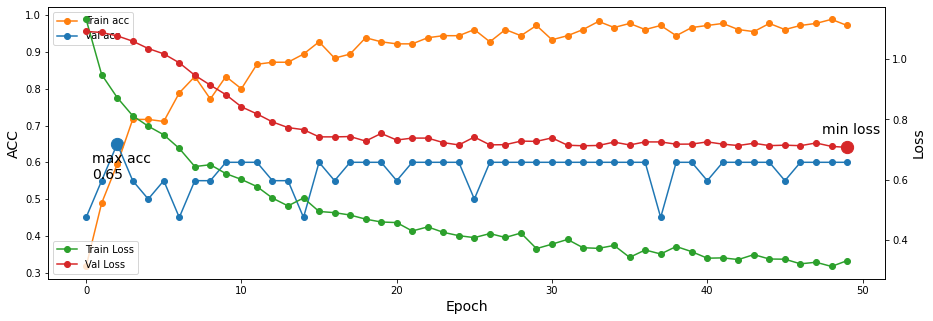

Training for fold 7 of 10...
Epoch 1/50
45/45 [==============================] - 17s 372ms/step - loss: 1.0903 - accuracy: 0.3944 - val_loss: 1.0917 - val_accuracy: 0.4000
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9520 - accuracy: 0.5556 - val_loss: 1.0846 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 8s 176ms/step - loss: 0.9001 - accuracy: 0.5833 - val_loss: 1.0751 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 173ms/step - loss: 0.8559 - accuracy: 0.6111 - val_loss: 1.0658 - val_accuracy: 0.6000
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7699 - accuracy: 0.6944 - val_loss: 1.0539 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7206 - accuracy: 0.7389 - val_loss: 1.0190 - val_accuracy: 0.5500
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6744 - accuracy: 0.8000 - val_loss: 0.9974

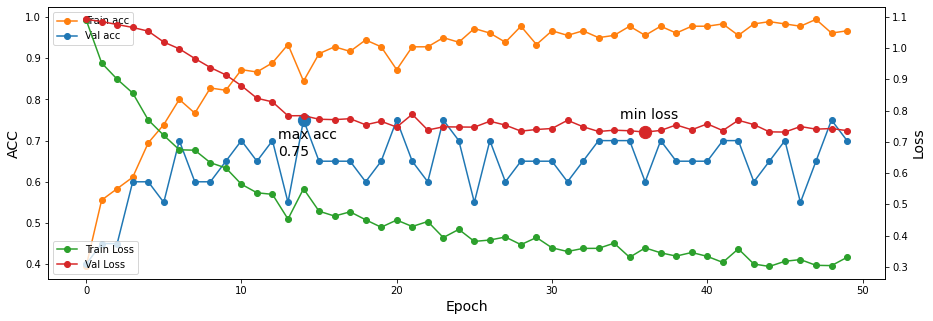

Training for fold 8 of 10...
Epoch 1/50
45/45 [==============================] - 17s 368ms/step - loss: 1.0447 - accuracy: 0.4722 - val_loss: 1.0922 - val_accuracy: 0.5000
Epoch 2/50
45/45 [==============================] - 8s 173ms/step - loss: 0.9807 - accuracy: 0.5111 - val_loss: 1.0898 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9236 - accuracy: 0.5889 - val_loss: 1.0840 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8482 - accuracy: 0.6444 - val_loss: 1.0764 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 8s 173ms/step - loss: 0.7818 - accuracy: 0.7111 - val_loss: 1.0698 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7188 - accuracy: 0.7444 - val_loss: 1.0408 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6946 - accuracy: 0.7889 - val_loss: 1.0321

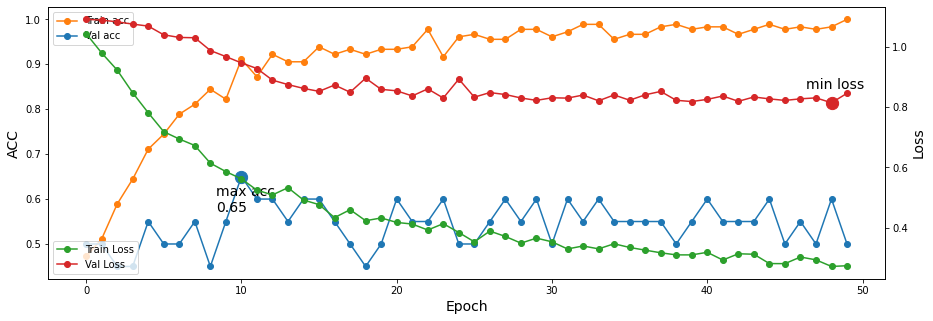

Training for fold 9 of 10...
Epoch 1/50
45/45 [==============================] - 17s 368ms/step - loss: 1.0512 - accuracy: 0.4333 - val_loss: 1.0952 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9593 - accuracy: 0.5667 - val_loss: 1.0897 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8558 - accuracy: 0.5944 - val_loss: 1.0740 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8384 - accuracy: 0.6278 - val_loss: 1.0744 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 8s 175ms/step - loss: 0.7904 - accuracy: 0.6778 - val_loss: 1.0661 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6957 - accuracy: 0.7778 - val_loss: 1.0433 - val_accuracy: 0.5000
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6780 - accuracy: 0.7611 - val_loss: 1.0186

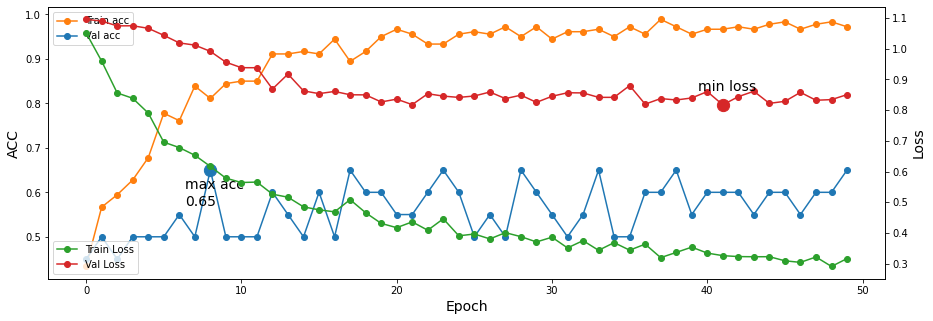

Training for fold 10 of 10...
Epoch 1/50
45/45 [==============================] - 17s 372ms/step - loss: 1.0482 - accuracy: 0.4722 - val_loss: 1.0921 - val_accuracy: 0.4737
Epoch 2/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9528 - accuracy: 0.4944 - val_loss: 1.0847 - val_accuracy: 0.4737
Epoch 3/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8373 - accuracy: 0.7278 - val_loss: 1.0706 - val_accuracy: 0.5789
Epoch 4/50
45/45 [==============================] - 8s 174ms/step - loss: 0.8141 - accuracy: 0.6333 - val_loss: 1.0594 - val_accuracy: 0.5263
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7862 - accuracy: 0.7056 - val_loss: 1.0379 - val_accuracy: 0.7368
Epoch 6/50
45/45 [==============================] - 8s 174ms/step - loss: 0.7413 - accuracy: 0.7611 - val_loss: 1.0166 - val_accuracy: 0.6316
Epoch 7/50
45/45 [==============================] - 8s 174ms/step - loss: 0.6488 - accuracy: 0.7667 - val_loss: 0.981

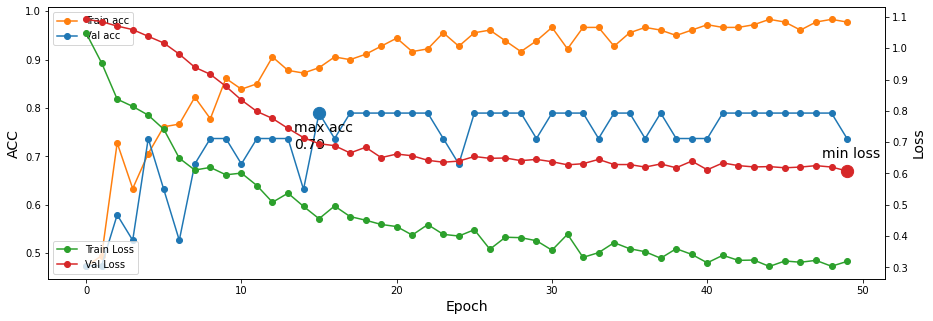

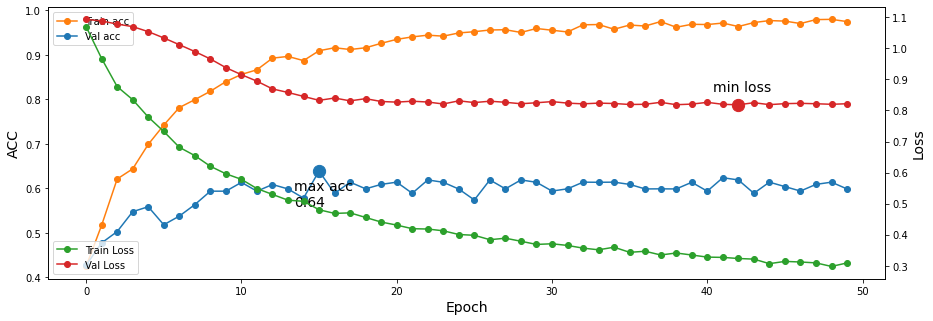

--------------------------------------------------------------------------------
Results per fold
--------------------------------------------------------------------------------
> Fold 1 - loss: 0.3119339942932129 - accuracy: 0.9888888597488403 - val_loss.: 0.8646969795227051 - val_accuracy: 0.5
--------------------------------------------------------------------------------
> Fold 2 - loss: 0.25064224004745483 - accuracy: 0.9944444298744202 - val_loss.: 1.0007264614105225 - val_accuracy: 0.6000000238418579
--------------------------------------------------------------------------------
> Fold 3 - loss: 0.2984864115715027 - accuracy: 0.9777777791023254 - val_loss.: 0.7780160307884216 - val_accuracy: 0.6000000238418579
--------------------------------------------------------------------------------
> Fold 4 - loss: 0.35847747325897217 - accuracy: 0.9333333373069763 - val_loss.: 0.9731532335281372 - val_accuracy: 0.44999998807907104
------------------------------------------------------

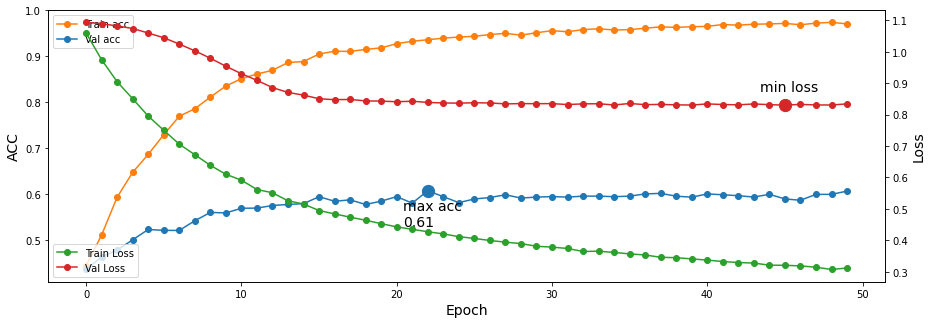

--------------------------------------------------------------------------------
Results per repetition (on last epoch)
--------------------------------------------------------------------------------
> Repetition 1 - Loss: 0.8232921600341797 - Accuracy : 0.6039473623037338
--------------------------------------------------------------------------------
> Repetition 2 - Loss: 0.8300902128219605 - Accuracy : 0.6236842036247253
--------------------------------------------------------------------------------
> Repetition 3 - Loss: 0.8360462963581086 - Accuracy : 0.598421061038971
--------------------------------------------------------------------------------
> Repetition 4 - Loss: 0.8589170098304748 - Accuracy : 0.6081578969955445
--------------------------------------------------------------------------------
> Repetition 5 - Loss: 0.8217524111270904 - Accuracy : 0.5986842095851899
--------------------------------------------------------------------------------
Average results over repe

In [20]:
select_dataset(2) # Standarized

metadata_train = pd.read_csv(METADATA_PATH + DS + '/train/train_summary.csv', encoding='utf-8')
metadata_test = pd.read_csv(METADATA_PATH + DS + '/test/test_summary.csv', encoding='utf-8')

X_train = DS_PATH + '/train/' + metadata_train.iloc[:, 0].to_numpy()
y_train = np.argmax(metadata_train.iloc[:,-len(CLASSES):].to_numpy(), axis=1)
X_test = DS_PATH + '/test/' + metadata_test.iloc[:, 0].to_numpy()
y_test = np.argmax(metadata_test.iloc[:,-len(CLASSES):].to_numpy(), axis=1)

# # =============================================================================
# # Train and test model 2 (and save results)
# # =============================================================================
# Select hyperparameters
# LR = 0.00001 #, 0.00008
# BATCH_SIZE = 4 #, 64
# EPOCHS = 50

# test_model_rkfold(build_model_2, 'pet-spatialnorm-elastic-standarized_model-2_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-standarized_model-2_results.txt')
# model = train_model(build_model_2)
# # model = tf.keras.models.load_model('pet-spatialnorm-elastic-standarized_model-2.h5') # Not used
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-standarized_model-2.h5')

# # =============================================================================
# # Train and test model 0 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_0, 'pet-spatialnorm-elastic-standarized_model-0_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-standarized_model-0_results.txt')
# model = train_model(build_model_0)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-standarized_model-0.h5')

# # =============================================================================
# # Train and test model 1 (and save results)
# # =============================================================================
# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_1, 'pet-spatialnorm-elastic-standarized_model-1_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-standarized_model-1_results.txt')
# model = train_model(build_model_1)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-standarized_model-1.h5')


# # ====================== Deeper model ======================

# LR = 0.00001
# BATCH_SIZE = 4
# EPOCHS = 50

# test_model_rkfold(build_model_3, 'pet-spatialnorm-elastic-standarized_model-3_results.txt')
# show_rkfold_results('pet-spatialnorm-elastic-standarized_model-3_results.txt')
# # model = train_model(build_model_3)
# # show_test_results(model)
# # model.save('pet-spatialnorm-elastic-standarized_model-3.h5')


# ====================== Deeper model ======================

LR = 0.00001
BATCH_SIZE = 4
EPOCHS = 50

test_model_rkfold(build_model_4, 'pet-spatialnorm-elastic-standarized_model-4_results.txt')
show_rkfold_results('pet-spatialnorm-elastic-standarized_model-4_results.txt')
# model = train_model(build_model_3)
# show_test_results(model)
# model.save('pet-spatialnorm-elastic-standarized_model-3.h5')


# K-fold results visualization

Cloning into 'Alzheimer-disease-classification'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (362/362), done.
remote: Total 435 (delta 186), reused 109 (delta 30), pack-reused 0
Receiving objects: 100% (435/435), 15.66 MiB | 15.81 MiB/s, done.
Resolving deltas: 100% (186/186), done.
 ===================== Results for model 3 =====================
 - Spatially normalized and standarized PET images


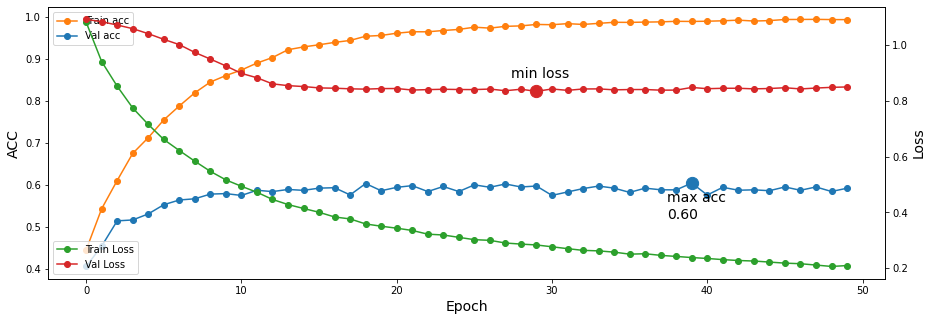

--------------------------------------------------------------------------------
Results per repetition (on last epoch)
--------------------------------------------------------------------------------
> Repetition 1 - Loss: 0.8599000692367553 - Accuracy : 0.6036842107772827
--------------------------------------------------------------------------------
> Repetition 2 - Loss: 0.8488978445529938 - Accuracy : 0.587894743680954
--------------------------------------------------------------------------------
> Repetition 3 - Loss: 0.8648214280605316 - Accuracy : 0.5626315832138061
--------------------------------------------------------------------------------
> Repetition 4 - Loss: 0.8266516029834747 - Accuracy : 0.6134210526943207
--------------------------------------------------------------------------------
> Repetition 5 - Loss: 0.8491427540779114 - Accuracy : 0.5884210586547851
--------------------------------------------------------------------------------
Average results over repe

In [21]:
if tf.io.gfile.exists('Alzheimer-disease-classification'):
    shutil.rmtree('Alzheimer-disease-classification')
! git clone https://github.com/Angelvj/Alzheimer-disease-classification.git

results_path = 'Alzheimer-disease-classification/kfold_results/'

EPOCHS = 50
REPS = 5

# # Model 0 results
# print(' ===================== Results for model 0 =====================')
# print(' - Spatially normalized PET images')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic_model-0_results.txt')
# print(' - Spatially normalized and max intensity normalized PET images')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic-maxintensitynorm_model-0_results.txt')
# print(' - Spatially normalized and standarized PET images')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic-standarized_model-0_results.txt')

# # Model 1 results
# print(' ===================== Results for model 1 =====================')
# print(' - Spatially normalized PET images')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic_model-1_results.txt')
# print(' - Spatially normalized and max intensity normalized PET images')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic-maxintensitynorm_model-1_results.txt')
# print(' - Spatially normalized and standarized PET images')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic-standarized_model-1_results.txt')

# # Model 2 results
# print(' ===================== Results for model 2 =====================')
# print(' - Spatially normalized PET images')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic_model-2_results.txt')
# print(' - Spatially normalized and max intensity normalized PET images')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic-maxintensitynorm_model-2_results.txt')
# print(' - Spatially normalized and standarized PET images')
# show_rkfold_results(results_path + 'pet-spatialnorm-elastic-standarized_model-2_results.txt')


# Model 3 results
print(' ===================== Results for model 3 =====================')
print(' - Spatially normalized and standarized PET images')
show_rkfold_results(results_path + 'pet-spatialnorm-elastic-standarized_model-3_results.txt')


